Trafik Kazalarından Yaralanma Şiddetinin Tahmini

Proje Amacı: Chicago’da meydana gelen trafik kazalarıyla ilgili bilgileri inceleyerek bir kazada insanların ne kadar yaralanabileceğini önceden tahmin edebilmektir. Elimizde, her kaza için hava durumu, yol koşulları, kazanın gündüz mü gece mi yaşandığı, yolun kaç şeritli olduğu, kazanın bir kavşakta gerçekleşip gerçekleşmediği, hız sınırı, kaç aracın karıştığı ve kazanın türü gibi birçok detay bulunmaktadır. Bu bilgiler kullanılarak “Bu kazada yaralanma hafif mi olurdu, ağır mı olurdu, yoksa hiç yaralanma olmaz mıydı?” sorusuna cevap aranmaktadır. Böyle bir çalışma sayesinde kazaların sonuçlarını önceden tahmin etmek, tehlikeli durumları daha iyi anlamak ve ileride benzer şartlar oluştuğunda ne tür sonuçların ortaya çıkabileceğine dair daha güçlü öngörüler oluşturmak mümkündür. Bunun sonucunda güvenliği artırmaya yönelik daha doğru kararlar alınabilir; örneğin belirli bölgelerde hız sınırının düzenlenmesi, ışıklandırmanın iyileştirilmesi veya yol koşullarının kazalara etkisinin daha iyi anlaşılması gibi önemli çıkarımlar sağlanabilir.


In [43]:
!pip install xgboost lightgbm

   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
    --------------------------------------- 1.0/72.0 MB 4.2 MB/s eta 0:00:17
   - -------------------------------------- 2.4/72.0 MB 5.6 MB/s eta 0:00:13
   - -------------------------------------- 2.9/72.0 MB 5.8 MB/s eta 0:00:12
   -- ------------------------------------- 4.7/72.0 MB 5.6 MB/s eta 0:00:13
   --- ------------------------------------ 6.0/72.0 MB 5.8 MB/s eta 0:00:12
   --- ------------------------------------ 6.6/72.0 MB 5.4 MB/s eta 0:00:13
   ---- ----------------------------------- 8.1/72.0 MB 5.5 MB/s eta 0:00:12
   ----- ---------------------------------- 9.7/72.0 MB 5.8 MB/s eta 0:00:11
   ------ --------------------------------- 11.0/72.0 MB 5.9 MB/s eta 0:00:11
   ------ --------------------------------- 12.6/72.0 MB 6.0 MB/s eta 0:00:10
   ------- -------

1- Kütüphanelerin Tanımlanması:

In [44]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import joblib
import warnings
warnings.filterwarnings('ignore')

sns.set(style='whitegrid')
RNG = 42
np.random.seed(RNG)

2- Veri yükleme:

In [2]:
# ==========================================
# 1. VERİ YÜKLEME
# ==========================================
print("--- Veri Yükleniyor ---")
df = pd.read_csv("Traffic_Crashes.csv")

--- Veri Yükleniyor ---


2- Veri İnceleme (Exploratory Review):
Bu aşamada elimizdeki veri setini genel hatlarıyla tanımayı amaçlıyoruz. Bu yaptığımız verinin içinde neler olduğunu anlamak, hangi tür bilgilerin yer aldığını görmek, hangi sütunların önemli olabileceğini fark etmek için yapılan ilk gözlemdir. Bu bölümde veri setinin büyüklüğüne bakılır; yani kaç satır ve kaç sütun olduğu görülür. Her bir sütunun ne anlama geldiği anlaşılmaya çalışılır. Eksik bilgi olup olmadığına, tekrar eden satırlar bulunup bulunmadığına ve verilerin türlerinin doğru şekilde tanımlanıp tanımlanmadığına bakılır. Bu inceleme, ileride yapılacak tüm işlemler için bir temel oluşturur. Çünkü veriyi yeterince tanımazsak, doğru bir hazırlık, analiz veya modelleme yapamayız. Bu aşama sayesinde veri setinin yapısı, sorunları ve potansiyel kullanım şekilleri hakkında genel bir fikir sahibi oluruz.

In [3]:
print("Orijinal veri boyutu:", df.shape)
print("Sütun sayısı:", len(df.columns))

Orijinal veri boyutu: (300000, 48)
Sütun sayısı: 48


In [4]:
# İlk 5 satırı göster
df.head()

,CRASH_RECORD_ID,CRASH_DATE_EST_I,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,...,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LOCATION
0,98df5755b18bc25a67163bb832c0fd2b72c41631ef6e7d...,NaN,02/03/2025 06:30:00 AM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,UNKNOWN,UNKNOWN,PEDESTRIAN,DIVIDED - W/MEDIAN (NOT RAISED),...,1.0,0.0,1.0,0.0,6,2,2,41.904354,-87.721531,POINT (-87.721531234586 41.904353607338)
1,4e85802a19266b7c4c848561724da842d34a2509a4d931...,NaN,06/16/2022 01:50:00 AM,30,NO CONTROLS,NO CONTROLS,RAIN,"DARKNESS, LIGHTED ROAD",PARKED MOTOR VEHICLE,ONE-WAY,...,1.0,0.0,0.0,0.0,1,5,6,41.800640,-87.620846,POINT (-87.620846187015 41.800640445503)
2,d747392bff241c36c7ecbc171143947f6b93896a72a4ce...,NaN,01/19/2024 06:11:00 PM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,FREEZING RAIN/DRIZZLE,DAYLIGHT,REAR END,CENTER TURN LANE,...,1.0,0.0,1.0,0.0,18,6,1,41.659126,-87.559433,POINT (-87.559432741943 41.659126189932)
3,54aa7076c5ff7e2667d07268186d95064cad67ffa84e89...,NaN,02/01/2025 01:00:00 PM,30,NO CONTROLS,NO CONTROLS,UNKNOWN,DAYLIGHT,REAR TO SIDE,DIVIDED - W/MEDIAN (NOT RAISED),...,0.0,0.0,2.0,0.0,13,7,2,41.705506,-87.535139,POINT (-87.535139453239 41.7055064825)
4,ac3f58b20d6ca95846e085b053618467d967c51f68d2c1...,NaN,07/14/2025 08:45:00 AM,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,SIDESWIPE SAME DIRECTION,NOT DIVIDED,...,0.0,0.0,2.0,0.0,8,2,7,41.850620,-87.632113,POINT (-87.632112683668 41.850620317342)


In [5]:
# Veri yapısı bilgisi
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 48 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   CRASH_RECORD_ID                300000 non-null  object 
 1   CRASH_DATE_EST_I               19194 non-null   object 
 2   CRASH_DATE                     300000 non-null  object 
 3   POSTED_SPEED_LIMIT             300000 non-null  int64  
 4   TRAFFIC_CONTROL_DEVICE         300000 non-null  object 
 5   DEVICE_CONDITION               300000 non-null  object 
 6   WEATHER_CONDITION              300000 non-null  object 
 7   LIGHTING_CONDITION             300000 non-null  object 
 8   FIRST_CRASH_TYPE               300000 non-null  object 
 9   TRAFFICWAY_TYPE                300000 non-null  object 
 10  LANE_CNT                       56674 non-null   float64
 11  ALIGNMENT                      300000 non-null  object 
 12  ROADWAY_SURFACE_COND          

In [6]:
# Veri tipi özet
print("\n--- Veri tipi özet ---")
print(df.dtypes.value_counts())


--- Veri tipi özet ---
object     31
float64    11
int64       6
Name: count, dtype: int64


In [7]:
# ------------------------------------------
# ### YENİ EKLEME (ADIM 3): MANTIKSAL TUTARLILIK KONTROLÜ (SANITY CHECK)
# ------------------------------------------
# Sayısal verilerdeki imkansız değerleri temizliyoruz.
# Örneğin: Hız sınırı negatif veya 100 mph üzeri olamaz (şehir içi).
print("\n--- Mantıksal Kontroller Yapılıyor ---")

# Hız sınırı kontrolü (0 ile 90 arası makul kabul edildi)
hatali_hiz_sayisi = df[(df['POSTED_SPEED_LIMIT'] < 0) | (df['POSTED_SPEED_LIMIT'] > 90)].shape[0]
if hatali_hiz_sayisi > 0:
    print(f"{hatali_hiz_sayisi} adet mantıksız hız sınırı değeri tespit edildi ve temizleniyor.")
    df = df[(df['POSTED_SPEED_LIMIT'] >= 0) & (df['POSTED_SPEED_LIMIT'] <= 90)]
else:
    print("Hız sınırları mantıksal aralıkta.")
# ------------------------------------------


--- Mantıksal Kontroller Yapılıyor ---
19 adet mantıksız hız sınırı değeri tespit edildi ve temizleniyor.


In [8]:
# Eksik değer analiz tablosu
eksik_sayisi = df.isnull().sum()
eksik_yuzdesi = (eksik_sayisi / len(df)) * 100

eksik_df = pd.DataFrame({
    'eksik_sayisi': eksik_sayisi,
    'eksik_yuzdesi': eksik_yuzdesi
}).sort_values(by='eksik_yuzdesi', ascending=False)

eksik_df.head(50)

,eksik_sayisi,eksik_yuzdesi
WORKERS_PRESENT_I,299554,99.857658
WORK_ZONE_TYPE,298689,99.569306
WORK_ZONE_I,298223,99.413963
DOORING_I,297618,99.212283
PHOTOS_TAKEN_I,295278,98.432234
STATEMENTS_TAKEN_I,289818,96.612119
NOT_RIGHT_OF_WAY_I,288431,96.149756
CRASH_DATE_EST_I,280787,93.601595
LANE_CNT,243312,81.109137
HIT_AND_RUN_I,215016,71.676540


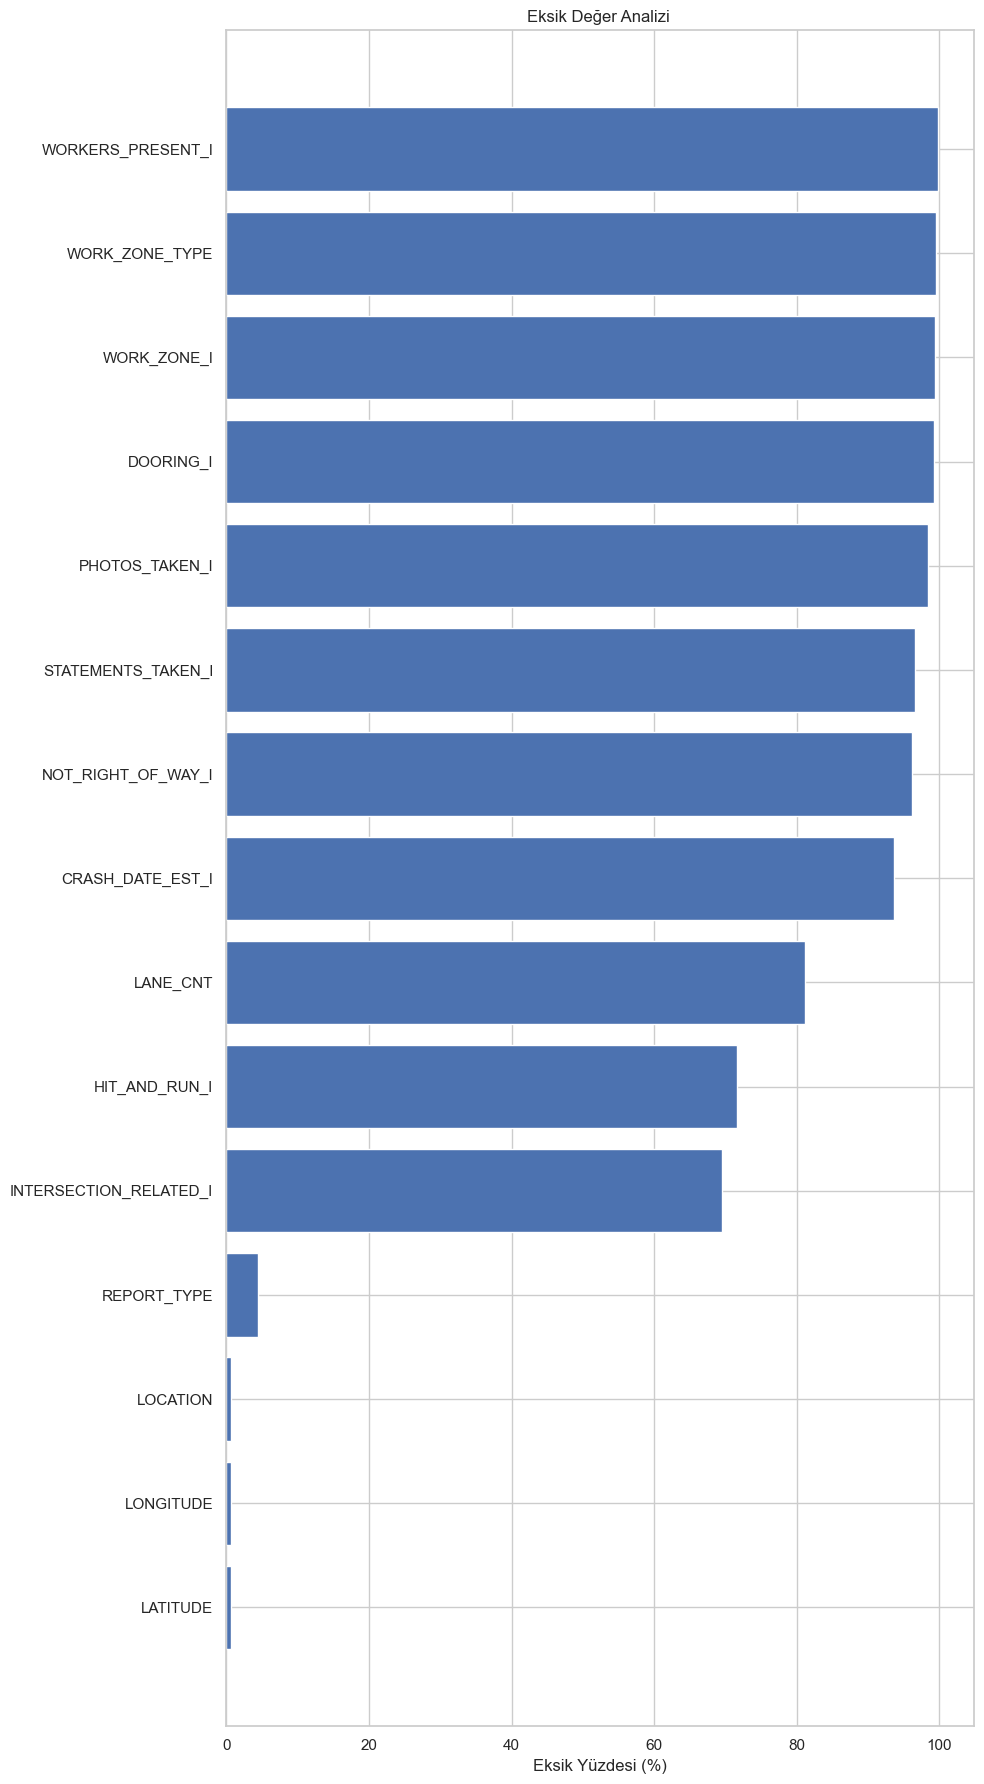

In [9]:
# Eksik değer tablosu 
eksik_sayisi = df.isnull().sum()
eksik_yuzdesi = (eksik_sayisi / len(df)) * 100

eksik_df = pd.DataFrame({
    'eksik_sayisi': eksik_sayisi,
    'eksik_yuzdesi': eksik_yuzdesi
}).sort_values(by='eksik_yuzdesi', ascending=False)

# --- GÖRSELLEŞTİRME ---
plt.figure(figsize=(10, 18))
plt.barh(eksik_df.head(15).index, eksik_df.head(15)['eksik_yuzdesi'])
plt.xlabel("Eksik Yüzdesi (%)")
plt.title("Eksik Değer Analizi ")
plt.gca().invert_yaxis()  # En yüksek değeri üstte göstermek için
plt.tight_layout()
plt.show()

In [10]:
df.nunique().sort_values(ascending=False).head(20)

CRASH_RECORD_ID                299981
DATE_POLICE_NOTIFIED           276882
CRASH_DATE                     262635
LOCATION                       146837
LATITUDE                       146832
LONGITUDE                      146830
STREET_NO                       10535
STREET_NAME                      1477
BEAT_OF_OCCURRENCE                276
INJURIES_NO_INDICATION             41
SEC_CONTRIBUTORY_CAUSE             40
PRIM_CONTRIBUTORY_CAUSE            40
POSTED_SPEED_LIMIT                 36
LANE_CNT                           27
CRASH_HOUR                         24
TRAFFICWAY_TYPE                    20
INJURIES_NON_INCAPACITATING        20
INJURIES_TOTAL                     20
TRAFFIC_CONTROL_DEVICE             19
FIRST_CRASH_TYPE                   18
dtype: int64

 4- Gereksiz Sütunların Silinmesi:
Bu sütunlar, çok fazla eksik değer içermeleri, modelleme sürecine anlamlı bir katkı sağlamamaları, bazıların coğrafi koordinatlardan oluşması ve analiz aşamasında gereksiz gürültü yaratma ihtimalleri nedeniyle veri setinden çıkarılır. Bu şekilde veri daha temiz, daha anlaşılır ve modelleme için daha uygun bir hale getirilmiş olur.

In [11]:
silinecek_sutunlar = [
    'WORKERS_PRESENT_I','DOORING_I','WORK_ZONE_TYPE','WORK_ZONE_I',
    'PHOTOS_TAKEN_I','STATEMENTS_TAKEN_I','NOT_RIGHT_OF_WAY_I',
    'CRASH_DATE_EST_I','LANE_CNT','INTERSECTION_RELATED_I','HIT_AND_RUN_I',
    'LATITUDE','LONGITUDE','CRASH_RECORD_ID','CRASH_DATE','DATE_POLICE_NOTIFIED',
    'STREET_NO','STREET_DIRECTION','STREET_NAME','LOCATION','REPORT_TYPE', 'BEAT_OF_OCCURRENCE'
]

df.drop(columns=silinecek_sutunlar, inplace=True)
print("Veri boyutu:", df.shape)

Veri boyutu: (299981, 26)


 5-Yaralanma Sütunlarının Silinmesi (Data Leakage Önleme): 
Bu aşamada, kazaların sonuçlarını doğrudan içeren yaralanma sütunları veri setinden çıkarılır. Çünkü bu bilgiler, tahmin etmeye çalıştığımız sonucun ta kendisidir. Eğer model bu sütunları görmeye devam ederse, tahmin sürecinde gerçek cevabı önceden öğrenmiş olur ve bu durum “veri sızıntısı” olarak adlandırılan hataya yol açar. Böyle bir durumda model gerçekte olduğundan çok daha başarılı görünür, ancak gerçek hayatta aynı performansı gösteremez. Bu nedenle yaralanma ile ilgili tüm sütunlar kaldırılarak, modelin yalnızca kazanın gerçekleştiği koşullara bakarak bağımsız bir şekilde tahmin yapması sağlanır. Bu işlem, modelin güvenilirliğini ve doğruluğunu artırmak için kritik bir adımdır.

In [12]:
# Yaralanma sütunlarını kaldırma (leakage engelleme)
leak_cols = [
    'INJURIES_TOTAL','INJURIES_FATAL','INJURIES_INCAPACITATING',
    'INJURIES_NON_INCAPACITATING','INJURIES_REPORTED_NOT_EVIDENT',
    'INJURIES_NO_INDICATION','INJURIES_UNKNOWN'
]

df.drop(columns=[c for c in leak_cols if c in df.columns], inplace=True)
print("Veri boyutu:", df.shape)


Veri boyutu: (299981, 19)


6- Hedef Değişkenin Belirlenmesi:
Bu aşamada, modelin tahmin etmeyi amaçlayacağı hedef değişken belirlenir. Projede amaç, bir trafik kazasında meydana gelen yaralanmanın şiddetini tahmin etmek olduğu için MOST_SEVERE_INJURY sütunu hedef olarak seçilir. Bu sütun, kazadaki yaralanmanın türünü içerir ve modelin öğrenmesi gereken temel bilgiyi temsil eder.

In [13]:
target = "MOST_SEVERE_INJURY"

X = df.drop(columns=[target])
y = df[target]


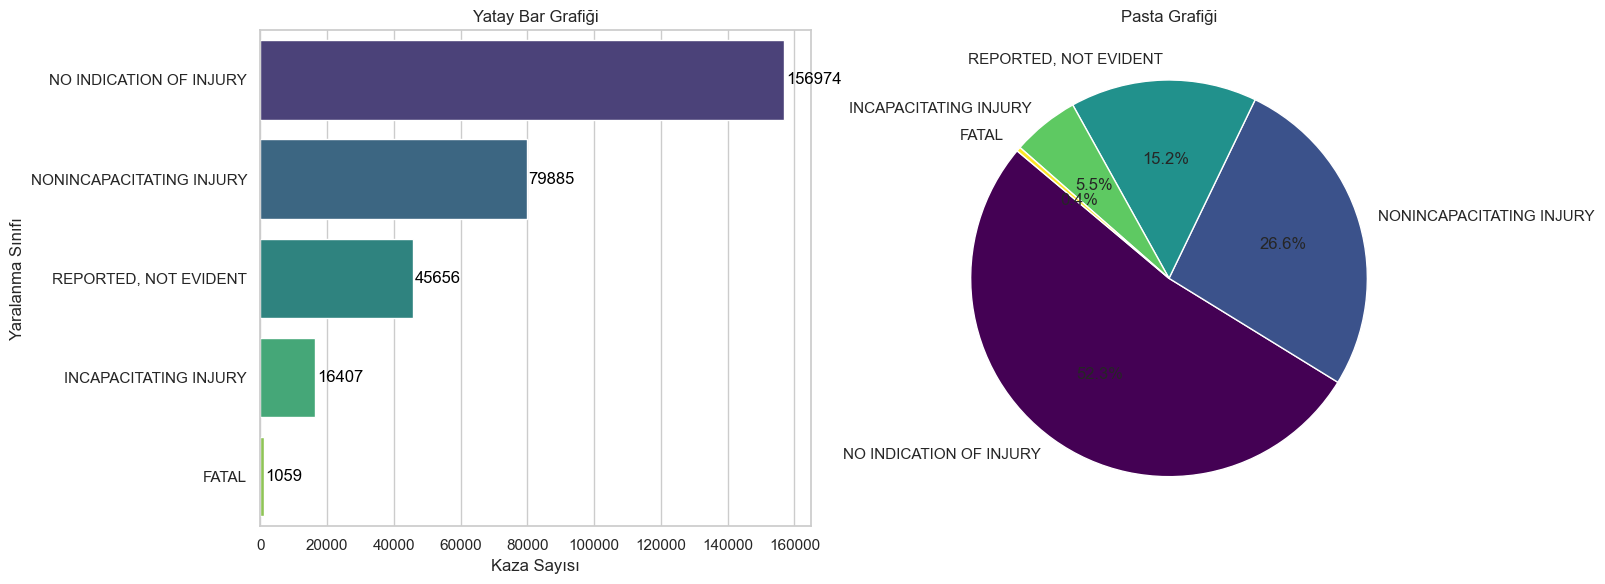

In [14]:
sayi = df[target].value_counts(dropna=False).sort_values(ascending=False)
etiketler = [str(i) if pd.notna(i) else 'NaN' for i in sayi.index]

plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
barlar_yatay = sns.barplot(y=etiketler, x=sayi.values, palette="viridis")
for i, v in enumerate(sayi.values):
    barlar_yatay.text(v + 500, i, str(v), color='black', va='center')
plt.title("Yatay Bar Grafiği")
plt.xlabel("Kaza Sayısı")
plt.ylabel("Yaralanma Sınıfı")

plt.subplot(1, 2, 2)
plt.pie(sayi.values, labels=etiketler, autopct='%1.1f%%', startangle=140,
        colors=plt.cm.viridis(np.linspace(0, 1, len(sayi))))
plt.title("Pasta Grafiği")
plt.tight_layout()
plt.show()

In [15]:
# ------------------------------------------
# ### YENİ EKLEME (ADIM 4): SINIF DENGESİZLİĞİ KONTROLÜ
# ------------------------------------------
print(f"\n--- Hedef Değişken ({target}) Sınıf Dağılımı ---")
sinif_dagilimi = df[target].value_counts(normalize=True) * 100
print(sinif_dagilimi)

if sinif_dagilimi.max() > 80:
    print("\n[UYARI] Ciddi bir sınıf dengesizliği var. Model eğitiminde 'class_weight' veya SMOTE kullanılması önerilir.")
else:
    print("\nSınıf dağılımı kabul edilebilir düzeyde.")
# ------------------------------------------


--- Hedef Değişken (MOST_SEVERE_INJURY) Sınıf Dağılımı ---
MOST_SEVERE_INJURY
NO INDICATION OF INJURY     52.327981
NONINCAPACITATING INJURY    26.630020
REPORTED, NOT EVIDENT       15.219631
INCAPACITATING INJURY        5.469346
FATAL                        0.353022
Name: proportion, dtype: float64

Sınıf dağılımı kabul edilebilir düzeyde.


7- Train/Test Ayırma: 
Veri setinde yalnızca temel temizlik işlemleri yapıldıktan sonra, yani veriye herhangi bir öğrenme veya çıkarım sağlayacak işlem uygulanmadan önce train/test ayırma işlemi erken bir aşamada gerçekleştirilir. Bu şekilde veri sızıntısı engellenmiş olur. Böylece daha sonra yapılacak tüm işlemler yalnızca eğitim verisine dayanarak öğrenilir ve test verisi tamamen bağımsız kalır.

In [16]:
# 1) %20 test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

# 2) %80 içinden %6.25 → %5 validation
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.0625,
    random_state=42,
    stratify=y_temp
)

print("Train:", X_train.shape)
print("Val:", X_val.shape)
print("Test:", X_test.shape)


Train: (224985, 18)
Val: (14999, 18)
Test: (59997, 18)


8- Keşifsel Veri Analizi (EDA) 
Keşifsel Veri Analizi, veri setini daha yakından tanımamızı sağlayan önemli bir aşamadır. Bu bölümde amaç, verilerin içerdiği ilişki ve örüntüleri görselleştirmeler ve istatistiksel özetler üzerinden keşfetmektir. Hangi değişkenlerin hangi değerlerde yoğunlaştığını, uç değerlerin olup olmadığını, kategorik değişkenlerin dağılımını, sayısal değişkenlerin genel eğilimlerini ve hedef değişken ile diğer sütunlar arasındaki ilişkileri anlamaya çalışırız. Böylece veri setinin güçlü yönlerini, sorunlu alanlarını ve modelin öğrenmesi açısından potansiyel etkisi olan değişkenleri daha net görürüz.

<Figure size 2000x600 with 0 Axes>

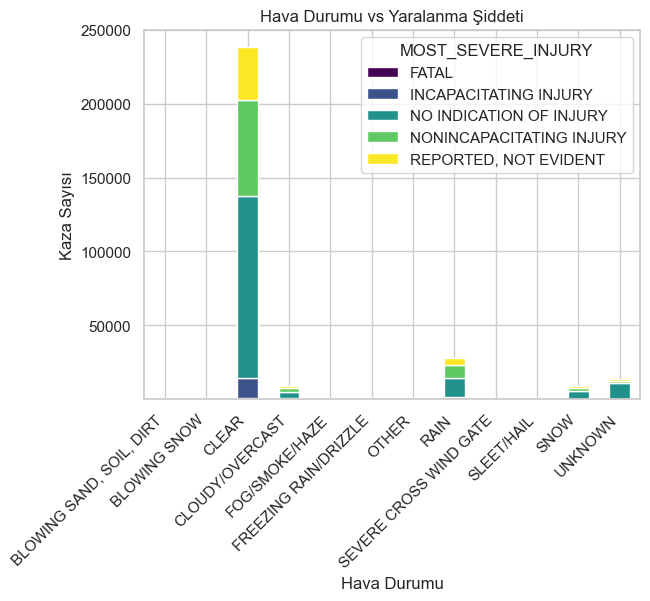

In [17]:
# WEATHER_CONDITION vs MOST_SEVERE_INJURY
plt.figure(figsize=(20,6))
cross = df.groupby(['WEATHER_CONDITION', 'MOST_SEVERE_INJURY']).size().unstack(fill_value=0)
cross.plot(kind='bar', stacked=True, colormap='viridis')
plt.title("Hava Durumu vs Yaralanma Şiddeti")
plt.xlabel("Hava Durumu")
plt.ylabel("Kaza Sayısı")
plt.xticks(rotation=45, ha='right')
plt.show()

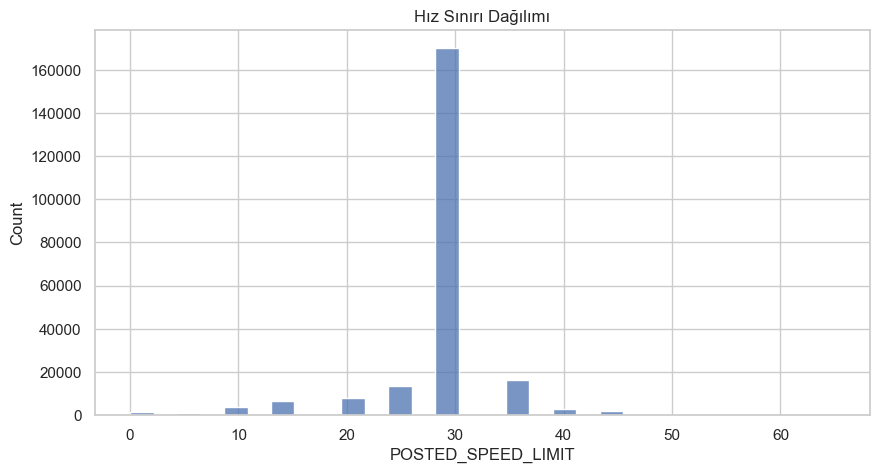

In [18]:
# Hız sınırı grafiği
plt.figure(figsize=(10,5))
sns.histplot(X_train['POSTED_SPEED_LIMIT'], bins=30)
plt.title("Hız Sınırı Dağılımı")
plt.show()

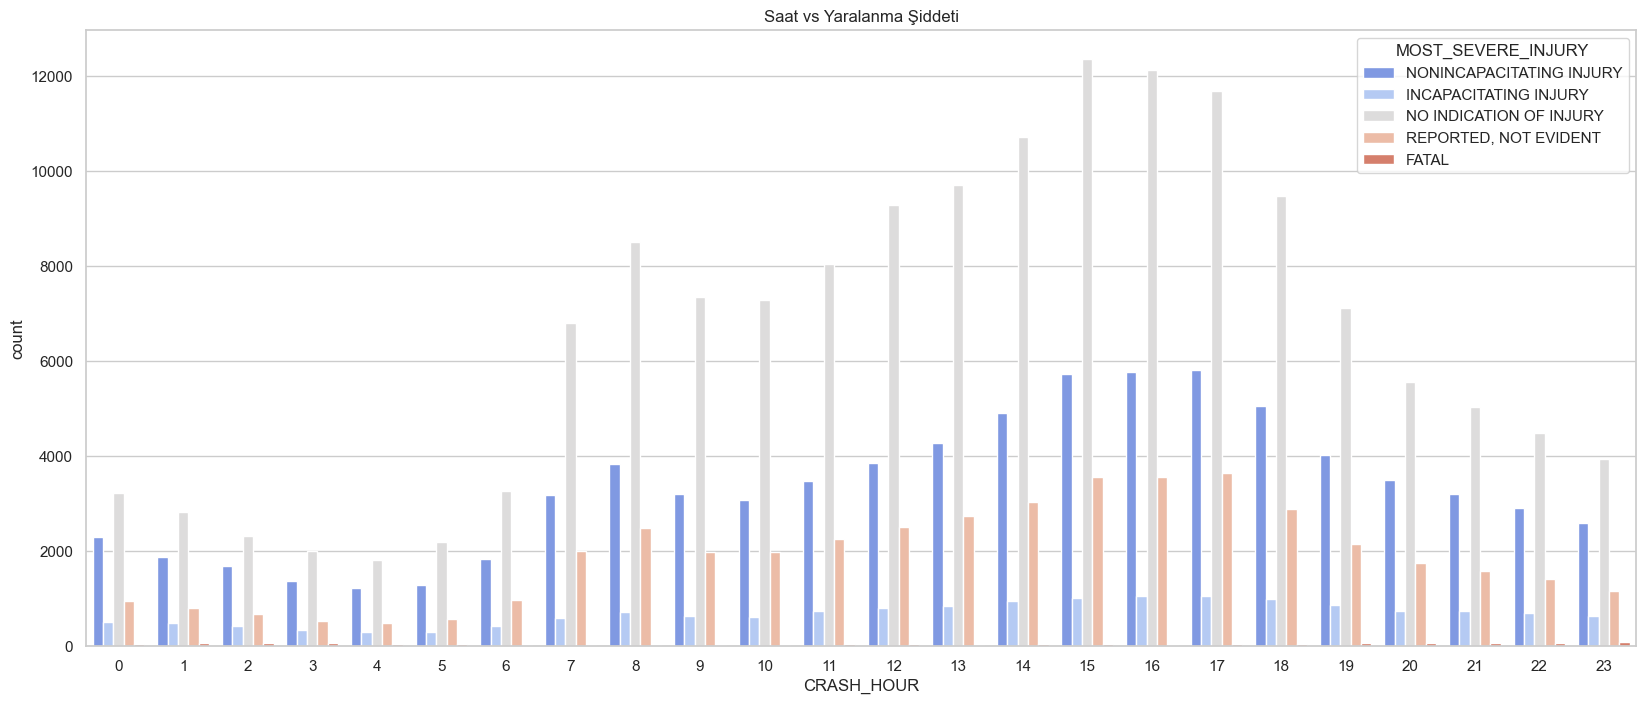

In [19]:
plt.figure(figsize=(20, 8))
sns.countplot(x='CRASH_HOUR', hue='MOST_SEVERE_INJURY', data=df, palette='coolwarm')
plt.title("Saat vs Yaralanma Şiddeti")
plt.show()


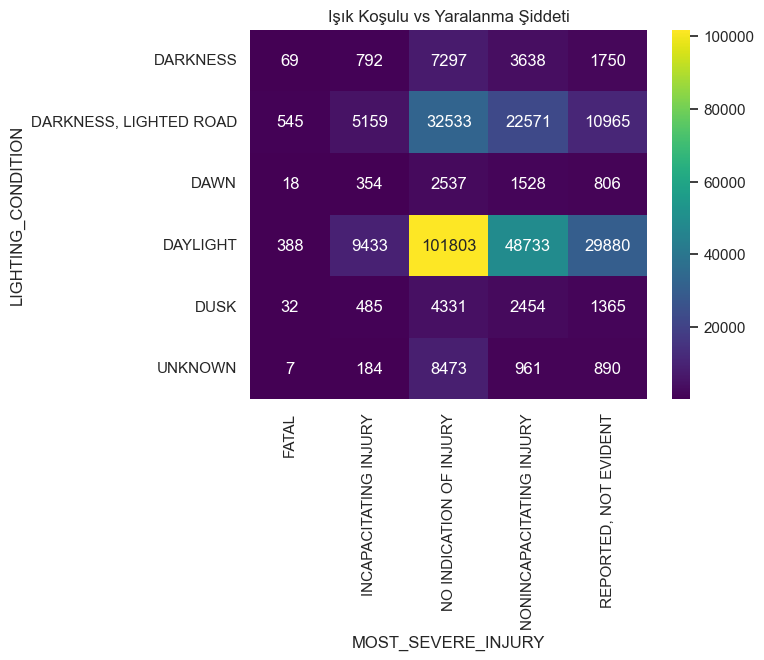

In [20]:
cross = df.groupby(['LIGHTING_CONDITION', 'MOST_SEVERE_INJURY']).size().unstack(fill_value=0)
sns.heatmap(cross, annot=True, fmt='d', cmap='viridis')
plt.title("Işık Koşulu vs Yaralanma Şiddeti")
plt.show()

In [21]:
# sayısal ve kategorik sütunları belirlenmesi
sayisal_sutunlar = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
kategorik_sutunlar = df.select_dtypes(include=['object']).columns.tolist()
# Hedef değişken sayısal listeden çıkarılıyor
if 'MOST_SEVERE_INJURY' in sayisal_sutunlar:
    sayisal_sutunlar.remove('MOST_SEVERE_INJURY')
if 'MOST_SEVERE_INJURY' in kategorik_sutunlar:
    kategorik_sutunlar.remove('MOST_SEVERE_INJURY')

print("Sayısal sütun sayısı:", len(sayisal_sutunlar))
print("Kategorik sütun sayısı:", len(kategorik_sutunlar))


Sayısal sütun sayısı: 5
Kategorik sütun sayısı: 13


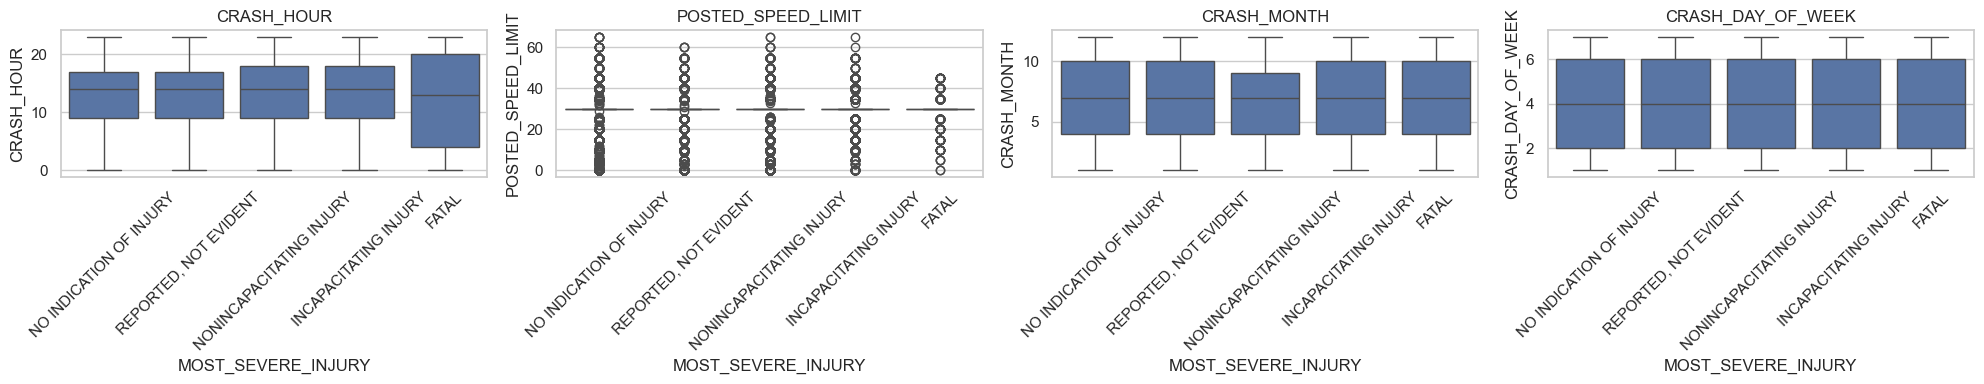

In [22]:
train_box_df = X_train.copy()
train_box_df["MOST_SEVERE_INJURY"] = y_train.values 

num_cols = train_box_df.select_dtypes(include=[np.number]).columns

var_series = train_box_df[num_cols].var().sort_values(ascending=False)
top_num_for_box = var_series.head(4).index

fig, axes = plt.subplots(1, len(top_num_for_box), figsize=(5 * len(top_num_for_box), 4))
if len(top_num_for_box) == 1:
    axes = [axes]

for ax, col in zip(axes, top_num_for_box):
    sns.boxplot(data=train_box_df, x="MOST_SEVERE_INJURY", y=col, ax=ax)
    ax.set_title(col)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

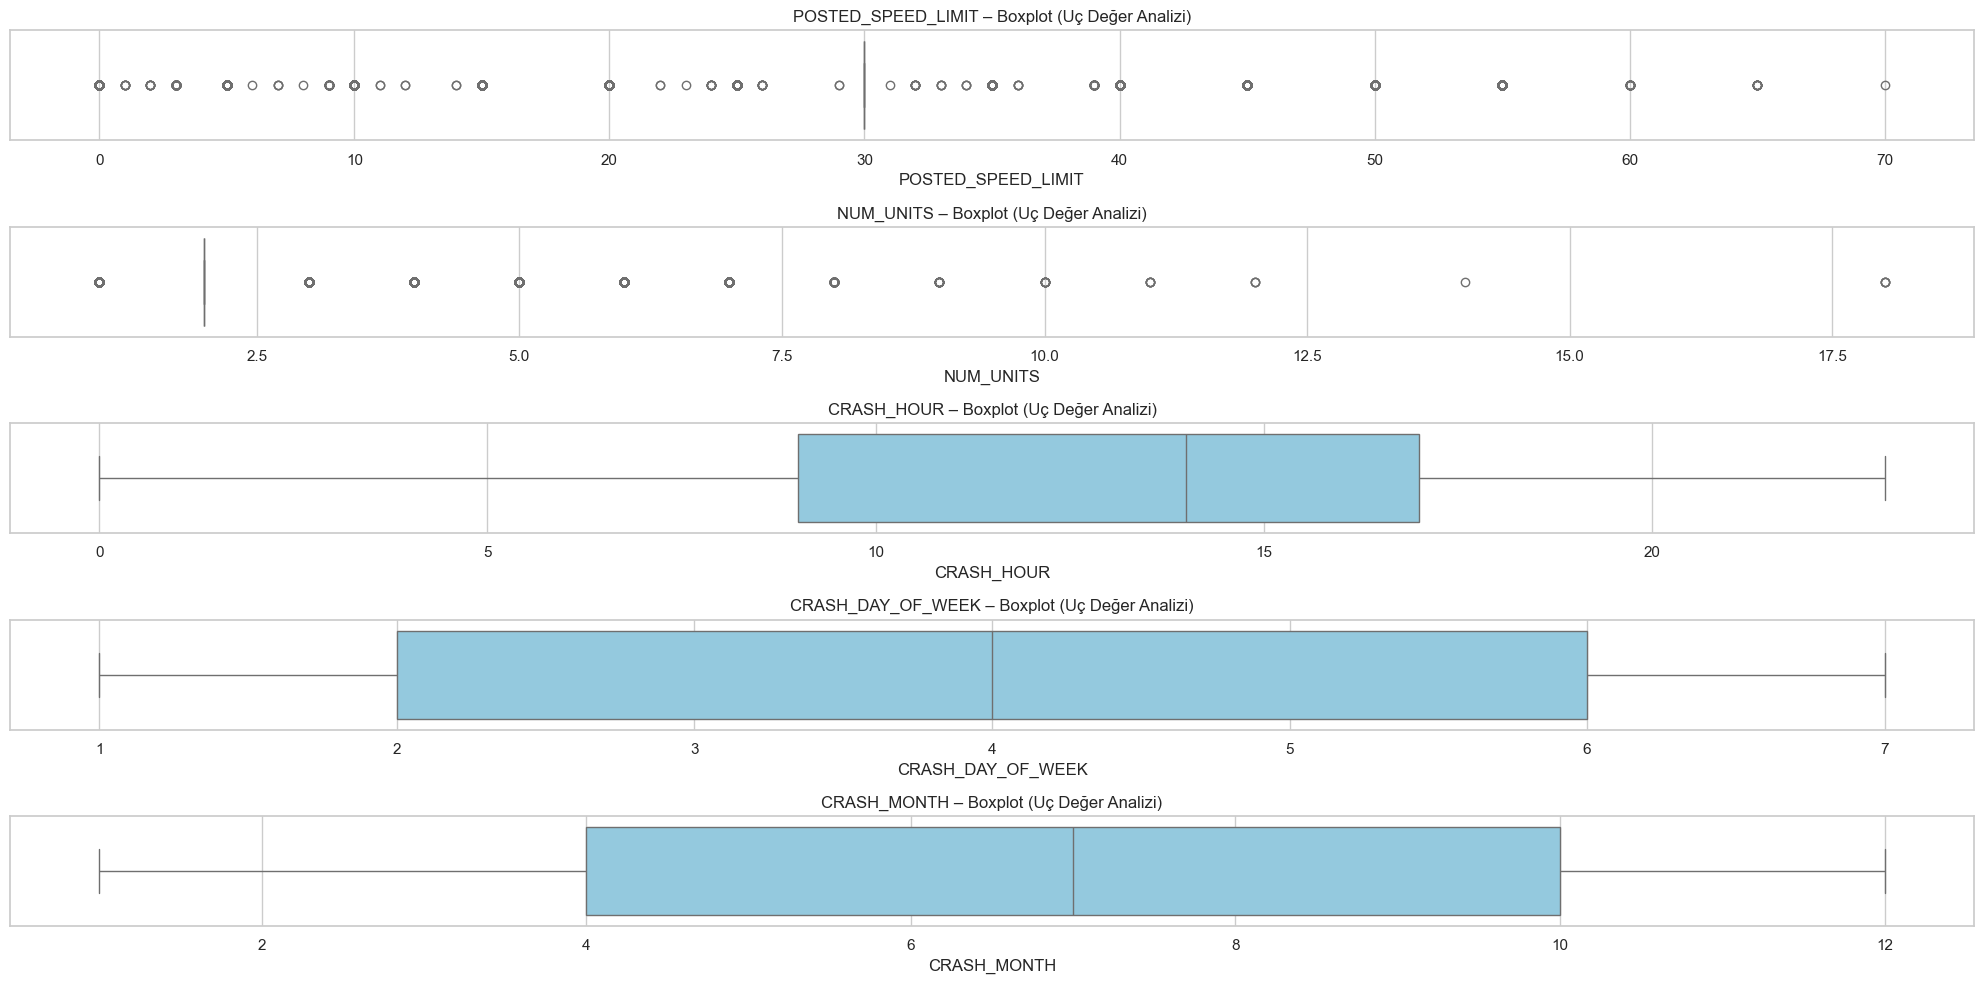

In [23]:
#SAYISAL SÜTUNLAR – UÇ DEĞER ANALİZİ
plt.figure(figsize=(20, len(sayisal_sutunlar) * 2))

for i, col in enumerate(sayisal_sutunlar, 1):
    plt.subplot(len(sayisal_sutunlar), 1, i)
    sns.boxplot(x=df[col], color='skyblue')
    plt.title(f"{col} – Boxplot (Uç Değer Analizi)", fontsize=12)

plt.tight_layout()
plt.show()

In [24]:
# 5. Aykırı Değerleri Belirleme 
outlier_report = {}
num_cols = X_train.select_dtypes(include=[np.number]).columns
for c in num_cols:
    q1 = X_train[c].quantile(0.25)
    q3 = X_train[c].quantile(0.75)
    iqr = q3 - q1
    upper = q3 + 1.5 * iqr
    lower = q1 - 1.5 * iqr
    outlier_rate = ((X_train[c] < lower) | (X_train[c] > upper)).mean() * 100
    outlier_report[c] = round(outlier_rate, 2)

outlier_df = pd.DataFrame(list(outlier_report.items()), columns=["Sütun", "Aykırı Değer Oranı (%)"])
outlier_df = outlier_df.sort_values(by="Aykırı Değer Oranı (%)", ascending=False)

print("\nAykırı değer oranı en yüksek sütunlar:")
print(outlier_df.head(10))


Aykırı değer oranı en yüksek sütunlar:
                Sütun  Aykırı Değer Oranı (%)
0  POSTED_SPEED_LIMIT                   24.46
1           NUM_UNITS                   15.27
2          CRASH_HOUR                    0.00
3   CRASH_DAY_OF_WEEK                    0.00
4         CRASH_MONTH                    0.00


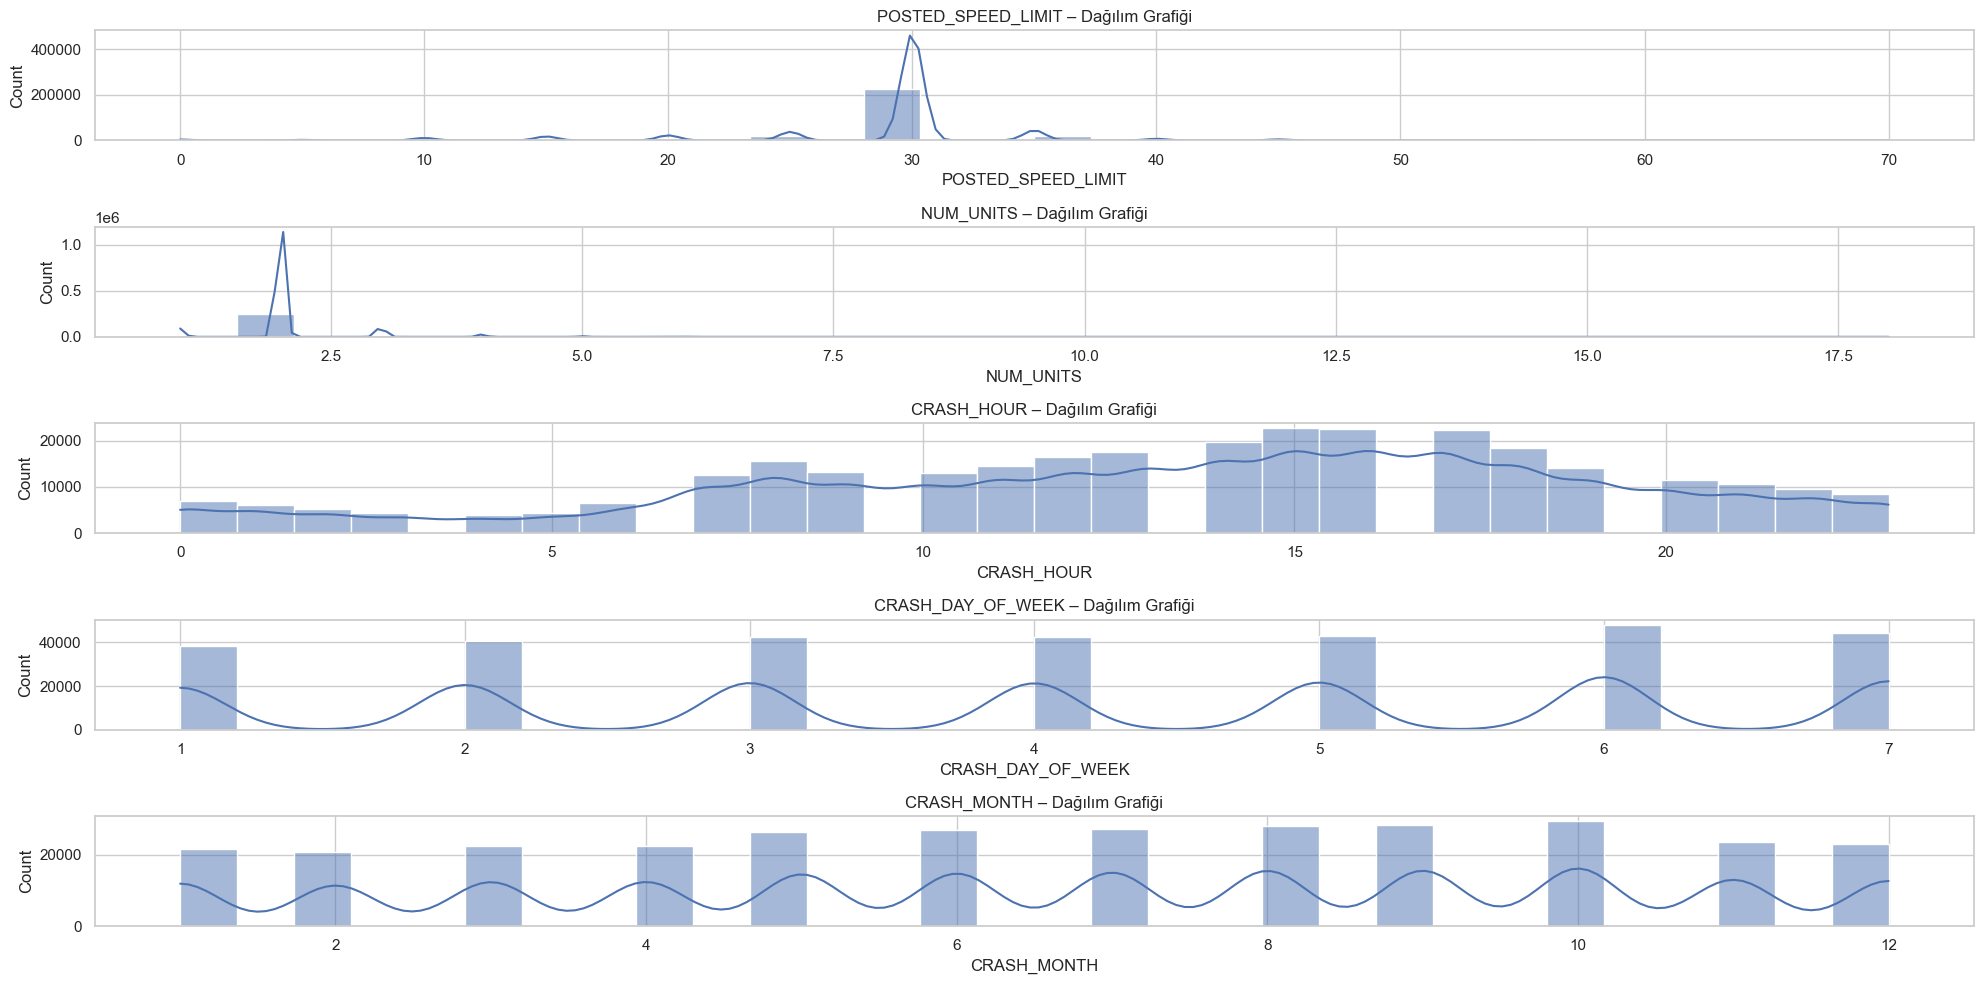

In [25]:
#SAYISAL DEĞİŞKENLERİN DAĞILIMI 
plt.figure(figsize=(20, len(sayisal_sutunlar) * 2))

for i, col in enumerate(sayisal_sutunlar, 1):
    plt.subplot(len(sayisal_sutunlar), 1, i)
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f"{col} – Dağılım Grafiği", fontsize=12)

plt.tight_layout()
plt.show()

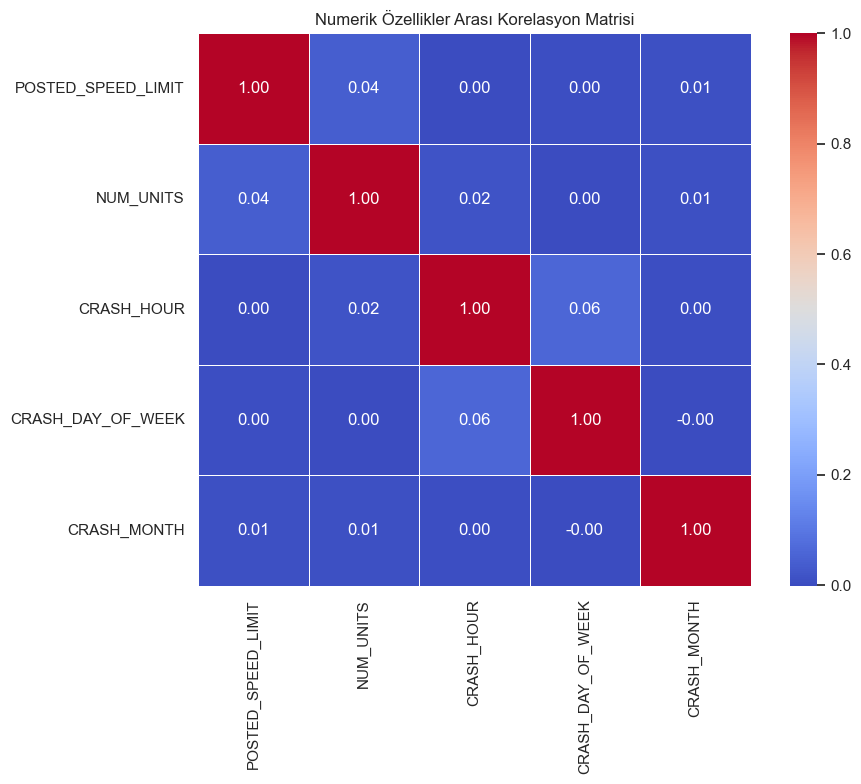

In [26]:
# =========================
# Amaç:
# - Numerik sütunların birbirleriyle olan ilişkisini (korelasyon) görmek
# - Çok güçlü ilişkili (yüksek korelasyonlu) değişkenleri tespit etmek
# - Gereksiz (birbirini tekrar eden) özellik olup olmadığını anlamak

# 1) Sadece numerik sütunları al
X_train_num_corr = X_train[sayisal_sutunlar].copy()

# 2) Korelasyon matrisi hesapla (varsayılan = Pearson)
corr_matrix = X_train_num_corr.corr()

# 3) Korelasyon matrisini görselleştir (heatmap)
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,           # Hücrelere korelasyon değerini yaz
    fmt=".2f",            # 2 basamak göster
    cmap="coolwarm",      # Renk paleti
    square=True,
    linewidths=0.5
)
plt.title("Numerik Özellikler Arası Korelasyon Matrisi")
plt.tight_layout()
plt.show()

In [27]:
# Veri yapısı bilgisi
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 299981 entries, 0 to 299999
Data columns (total 19 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   POSTED_SPEED_LIMIT       299981 non-null  int64 
 1   TRAFFIC_CONTROL_DEVICE   299981 non-null  object
 2   DEVICE_CONDITION         299981 non-null  object
 3   WEATHER_CONDITION        299981 non-null  object
 4   LIGHTING_CONDITION       299981 non-null  object
 5   FIRST_CRASH_TYPE         299981 non-null  object
 6   TRAFFICWAY_TYPE          299981 non-null  object
 7   ALIGNMENT                299981 non-null  object
 8   ROADWAY_SURFACE_COND     299981 non-null  object
 9   ROAD_DEFECT              299981 non-null  object
 10  CRASH_TYPE               299981 non-null  object
 11  DAMAGE                   299981 non-null  object
 12  PRIM_CONTRIBUTORY_CAUSE  299981 non-null  object
 13  SEC_CONTRIBUTORY_CAUSE   299981 non-null  object
 14  NUM_UNITS                

9. Veri Ön İşleme (Preprocessing) Hattı
Makine öğrenmesi modellerinin veriyi işleyebilmesi için bir dönüşüm hattı (pipeline) kurulmuştur:

Sayısal Değişkenler: Eksik veriler medyan ile doldurulmuş ve StandardScaler ile ölçeklendirilmiştir. Bu, özellikle Lojistik Regresyon gibi mesafeye dayalı modellerin performansı için gereklidir.

Kategorik Değişkenler: Eksik veriler en sık tekrar eden değer (mod) ile doldurulmuş ve One-Hot Encoding yöntemi ile sayısal vektörlere dönüştürülmüştür.

In [28]:
#  Transformer'ların tanımı
#    - Numeric: median ile doldur, StandardScaler uygula
#    - Categorical: en sık değer ile doldur, OneHotEncoder(handle_unknown='ignore')
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
    # Not: sparse=False küçük/orta boyutlu datasetlerde kolaylık sağlar; büyük datasetlerde memory dikkat.
])

In [29]:
#ColumnTransformer oluştur
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, sayisal_sutunlar),
    ('cat', categorical_transformer, kategorik_sutunlar)
], remainder='drop')  # remainder='drop' -> bilinmeyen sütunlar atılır

print("Preprocessor oluşturuldu.")

Preprocessor oluşturuldu.


In [30]:
# Preprocessor'ı X_train üzerinde fit et ve dönüştür
preprocessor.fit(X_train)

X_train_proc = preprocessor.transform(X_train)
X_val_proc = preprocessor.transform(X_val)
X_test_proc = preprocessor.transform(X_test)

print("Dönüştürülmüş şekiller:")
print("X_train_proc:", X_train_proc.shape)
print("X_val_proc:  ", X_val_proc.shape)
print("X_test_proc: ", X_test_proc.shape)

Dönüştürülmüş şekiller:
X_train_proc: (224985, 193)
X_val_proc:   (14999, 193)
X_test_proc:  (59997, 193)


In [31]:
# Örnek çıktı (ilk 5 satır)
# Feature isimlerini al
try:
    cat_features = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(kategorik_sutunlar)
except:
    cat_features = preprocessor.named_transformers_['cat']['onehot'].get_feature_names(kategorik_sutunlar)

num_features = sayisal_sutunlar
all_features = list(num_features) + list(cat_features)

X_train_df = pd.DataFrame(X_train_proc, columns=all_features, index=X_train.index)
print("Örnek dönüştürülmüş veri (ilk 5 satır):")
print(X_train_df.head())

Örnek dönüştürülmüş veri (ilk 5 satır):
        POSTED_SPEED_LIMIT  NUM_UNITS  CRASH_HOUR  CRASH_DAY_OF_WEEK  \
258699            0.198835  -0.136434    0.137426           1.456643   
7792              0.198835  -0.136434    1.014631          -0.055242   
134179            1.092447  -0.136434   -0.739779          -0.055242   
36400             1.092447  -0.136434    1.716395           0.448719   
83606             0.198835  -0.136434   -2.143306          -1.567127   

        CRASH_MONTH  TRAFFIC_CONTROL_DEVICE_BICYCLE CROSSING SIGN  \
258699    -1.714436                                           0.0   
7792      -0.512914                                           0.0   
134179    -1.113675                                           0.0   
36400      0.388227                                           0.0   
83606     -0.212534                                           0.0   

        TRAFFIC_CONTROL_DEVICE_DELINEATORS  \
258699                                 0.0   
7792                

10. Modelleme Stratejisi ve Deneysel Karşılaştırma
Model başarısını ölçmek için üç farklı senaryo kurgulanmıştır:
Base (Temel) Senaryo: Tüm özniteliklerin kullanıldığı ham yaklaşım.
Feature Selection (Özellik Seçimi): Yalnızca en önemli özelliklerin seçildiği senaryo.
PCA (Temel Bileşen Analizi): Verinin varyansının %95'ini koruyacak şekilde boyut indirgeme yapılan senaryo.
Her senaryoda Logistic Regression (doğrusal bir model) ve Random Forest (kolektif öğrenme modeli) eğitilmiş; Accuracy, F1-Score, Precision ve Recall metrikleri üzerinden karşılaştırmalı analiz yapılmıştır. Sınıf dengesizliği olduğu için özellikle Macro F1-Score metriğine odaklanılmıştır.

In [32]:
# 2. Base modelleri tanımla
models = {
    'LogisticRegression': LogisticRegression(max_iter=5, class_weight='balanced', random_state=RNG),
    'RandomForest': RandomForestClassifier(n_estimators=20, random_state=RNG, class_weight='balanced')
}

def evaluate_model(model, X_train, y_train, X_val, y_val, stage_name=""):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    print(f"\n=== {stage_name} ===")
    print("Accuracy:", accuracy_score(y_val, y_pred))
    print("F1 Macro:", f1_score(y_val, y_pred, average='macro'))
    print("Recall Macro:", recall_score(y_val, y_pred, average='macro'))
    print("Precision Macro:", precision_score(y_val, y_pred, average='macro'))
    print("\nClassification Report:\n", classification_report(y_val, y_pred))

    cm = confusion_matrix(y_val, y_pred, labels=np.unique(y))
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
    plt.title(f"{stage_name} - Confusion Matrix")
    plt.show()



=== LogisticRegression (Base) ===
Accuracy: 0.6019067937862524
F1 Macro: 0.38161171050519616
Recall Macro: 0.5098305234730536
Precision Macro: 0.4181100509813202

Classification Report:
                           precision    recall  f1-score   support

                   FATAL       0.02      0.64      0.03        53
   INCAPACITATING INJURY       0.15      0.35      0.21       820
 NO INDICATION OF INJURY       1.00      0.86      0.92      7849
NONINCAPACITATING INJURY       0.53      0.22      0.31      3994
   REPORTED, NOT EVIDENT       0.39      0.48      0.43      2283

                accuracy                           0.60     14999
               macro avg       0.42      0.51      0.38     14999
            weighted avg       0.73      0.60      0.64     14999



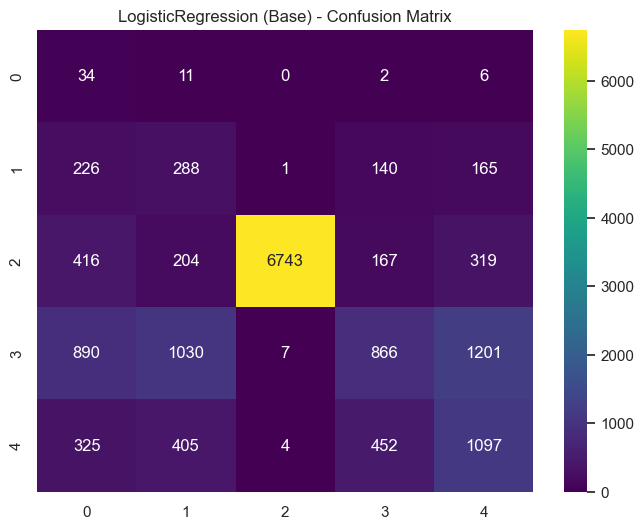


=== RandomForest (Base) ===
Accuracy: 0.7024468297886526
F1 Macro: 0.37697662714530183
Recall Macro: 0.3848178441633414
Precision Macro: 0.3920512819470148

Classification Report:
                           precision    recall  f1-score   support

                   FATAL       0.00      0.00      0.00        53
   INCAPACITATING INJURY       0.12      0.03      0.05       820
 NO INDICATION OF INJURY       0.93      0.89      0.91      7849
NONINCAPACITATING INJURY       0.51      0.73      0.60      3994
   REPORTED, NOT EVIDENT       0.40      0.28      0.33      2283

                accuracy                           0.70     14999
               macro avg       0.39      0.38      0.38     14999
            weighted avg       0.69      0.70      0.69     14999



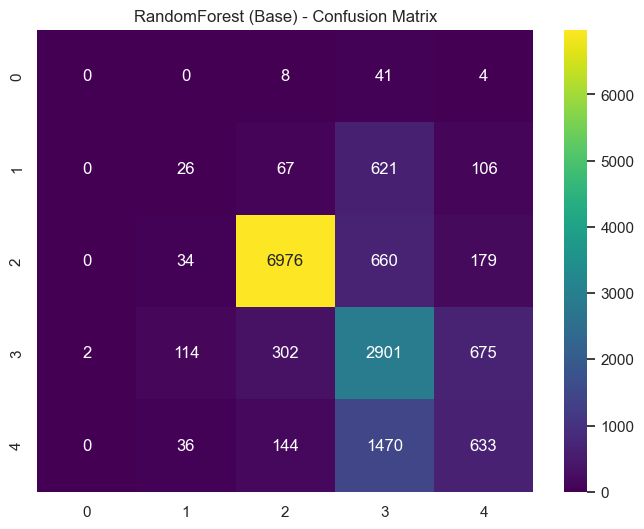

In [33]:
#  Base Modelleri Feature Selection Olmadan
X_train_proc = preprocessor.fit_transform(X_train)
X_val_proc = preprocessor.transform(X_val)

for name, model in models.items():
    evaluate_model(model, X_train_proc, y_train, X_val_proc, y_val, stage_name=f"{name} (Base)")


=== LogisticRegression (Feature Selection) ===
Accuracy: 0.601840122674845
F1 Macro: 0.3814075993354614
Recall Macro: 0.5092740242155511
Precision Macro: 0.4181625997797619

Classification Report:
                           precision    recall  f1-score   support

                   FATAL       0.02      0.64      0.03        53
   INCAPACITATING INJURY       0.15      0.35      0.21       820
 NO INDICATION OF INJURY       1.00      0.86      0.92      7849
NONINCAPACITATING INJURY       0.53      0.22      0.31      3994
   REPORTED, NOT EVIDENT       0.39      0.48      0.43      2283

                accuracy                           0.60     14999
               macro avg       0.42      0.51      0.38     14999
            weighted avg       0.73      0.60      0.64     14999



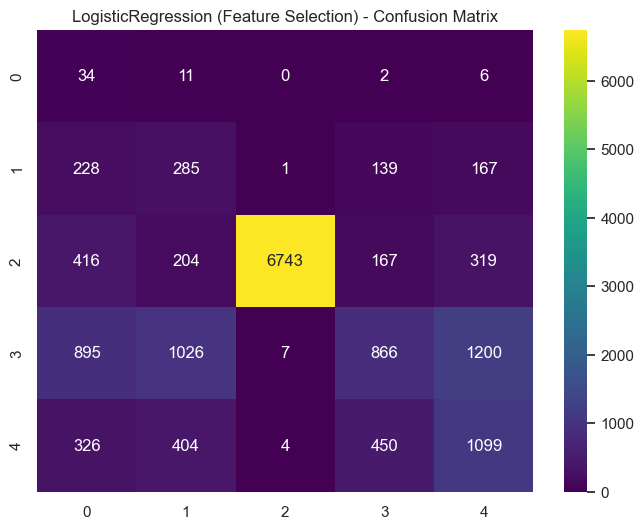


=== RandomForest (Feature Selection) ===
Accuracy: 0.701113407560504
F1 Macro: 0.37827720118595415
Recall Macro: 0.38503907226968376
Precision Macro: 0.3950479760041798

Classification Report:
                           precision    recall  f1-score   support

                   FATAL       0.00      0.00      0.00        53
   INCAPACITATING INJURY       0.14      0.04      0.06       820
 NO INDICATION OF INJURY       0.93      0.89      0.91      7849
NONINCAPACITATING INJURY       0.51      0.72      0.59      3994
   REPORTED, NOT EVIDENT       0.39      0.28      0.33      2283

                accuracy                           0.70     14999
               macro avg       0.40      0.39      0.38     14999
            weighted avg       0.69      0.70      0.69     14999



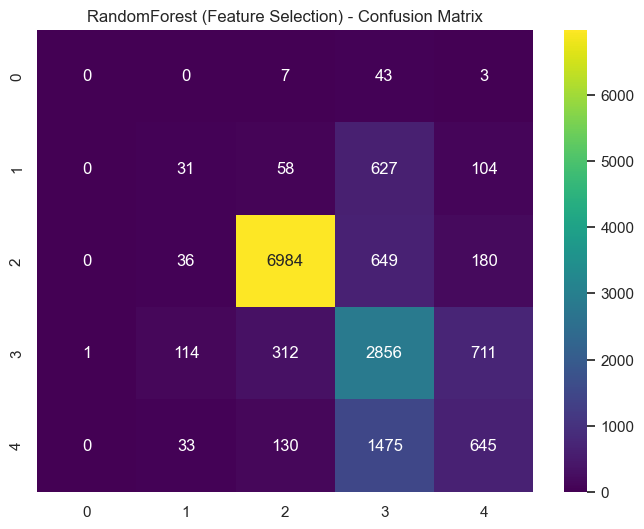

In [34]:
# Feature Selection + Base Modeller
fs_selector = SelectFromModel(RandomForestClassifier(n_estimators=10, random_state=RNG), threshold='median')
X_train_fs = fs_selector.fit_transform(X_train_proc, y_train)
X_val_fs = fs_selector.transform(X_val_proc)

for name, model in models.items():
    evaluate_model(model, X_train_fs, y_train, X_val_fs, y_val, stage_name=f"{name} (Feature Selection)")


=== LogisticRegression (PCA) ===
Accuracy: 0.6065071004733649
F1 Macro: 0.3830197981617577
Recall Macro: 0.5168805668615916
Precision Macro: 0.4192787832184382

Classification Report:
                           precision    recall  f1-score   support

                   FATAL       0.02      0.72      0.04        53
   INCAPACITATING INJURY       0.14      0.26      0.18       820
 NO INDICATION OF INJURY       1.00      0.86      0.92      7849
NONINCAPACITATING INJURY       0.54      0.23      0.33      3994
   REPORTED, NOT EVIDENT       0.39      0.52      0.45      2283

                accuracy                           0.61     14999
               macro avg       0.42      0.52      0.38     14999
            weighted avg       0.74      0.61      0.65     14999



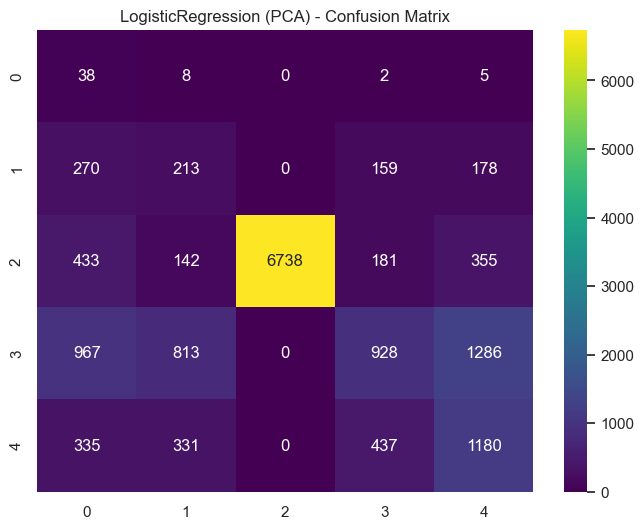


=== RandomForest (PCA) ===
Accuracy: 0.6985799053270219
F1 Macro: 0.3755354820276978
Recall Macro: 0.3809550566497872
Precision Macro: 0.3963750477283916

Classification Report:
                           precision    recall  f1-score   support

                   FATAL       0.00      0.00      0.00        53
   INCAPACITATING INJURY       0.17      0.05      0.08       820
 NO INDICATION OF INJURY       0.90      0.90      0.90      7849
NONINCAPACITATING INJURY       0.51      0.71      0.60      3994
   REPORTED, NOT EVIDENT       0.40      0.25      0.31      2283

                accuracy                           0.70     14999
               macro avg       0.40      0.38      0.38     14999
            weighted avg       0.68      0.70      0.68     14999



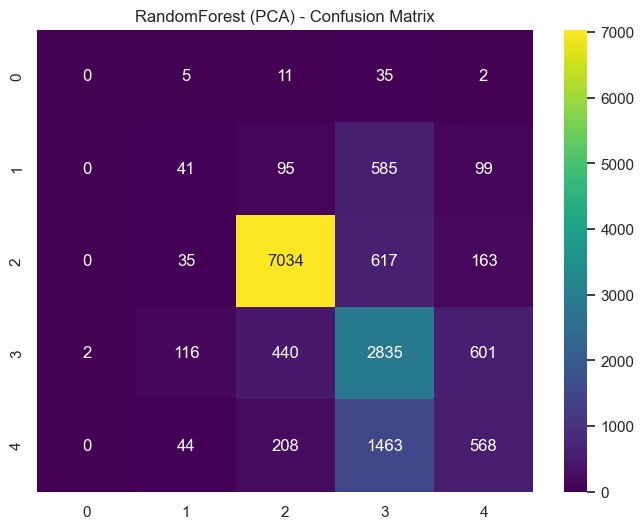

In [35]:
# PCA + Base Modeller
pca = PCA(n_components=0.95, random_state=RNG)
X_train_pca = pca.fit_transform(X_train_proc)
X_val_pca = pca.transform(X_val_proc)

for name, model in models.items():
    evaluate_model(model, X_train_pca, y_train, X_val_pca, y_val, stage_name=f"{name} (PCA)")

11. Test Seti Sonuçları ve Değerlendirme
Eğitilen modeller, daha önce hiç görmedikleri Test Seti üzerinde sınanmıştır. Aşağıdaki tablolar ve grafikler, Feature Selection ve PCA işlemlerinin model performansı üzerindeki etkisini göstermektedir. Özellikle Feature Selection işleminin, modelin karmaşıklığını azaltırken başarı oranını koruyup korumadığı veya artırıp artırmadığı (Trade-off) bu aşamada değerlendirilmiştir.

In [36]:
# Test Seti Performansları
stages = {
    'Base': X_train_proc,
    'Feature Selection': X_train_fs,
    'PCA': X_train_pca
}

results = []

for stage_name, X_tr in stages.items():
    for model_name, model in models.items():
        model.fit(X_tr, y_train)
        X_test_tr = preprocessor.transform(X_test)
        if stage_name == 'Feature Selection':
            X_test_tr = fs_selector.transform(X_test_tr)
        elif stage_name == 'PCA':
            X_test_tr = pca.transform(X_test_tr)
        y_pred = model.predict(X_test_tr)
        results.append({
            'Stage': stage_name,
            'Model': model_name,
            'Accuracy': accuracy_score(y_test, y_pred),
            'F1 Macro': f1_score(y_test, y_pred, average='macro'),
            'Recall Macro': recall_score(y_test, y_pred, average='macro'),
            'Precision Macro': precision_score(y_test, y_pred, average='macro')
        })

results_df = pd.DataFrame(results)
print("\n--- Test Seti Sonuçları ---")
display(results_df)



--- Test Seti Sonuçları ---


,Stage,Model,Accuracy,F1 Macro,Recall Macro,Precision Macro
0,Base,LogisticRegression,0.596246,0.375759,0.477801,0.413055
1,Base,RandomForest,0.702635,0.383303,0.389224,0.425832
2,Feature Selection,LogisticRegression,0.596096,0.375555,0.477476,0.412863
3,Feature Selection,RandomForest,0.700968,0.384080,0.389208,0.418632
4,PCA,LogisticRegression,0.601663,0.379561,0.490433,0.414365
5,PCA,RandomForest,0.692901,0.379338,0.382374,0.428588


In [37]:
#. FS + PCA + Base Model Pipeline
combined_results = []

for model_name, base_model in models.items():
    print(f"\n=== {model_name} için FS + PCA + Base Model ===")
    
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('fs', SelectFromModel(RandomForestClassifier(n_estimators=10, random_state=RNG), threshold='median')),
        ('pca', PCA(n_components=0.95, random_state=RNG)),
        ('model', base_model)
    ])
    
    # Validation performansı
    pipeline.fit(X_train, y_train)
    y_val_pred = pipeline.predict(X_val)
    
    acc_val = accuracy_score(y_val, y_val_pred)
    f1_val = f1_score(y_val, y_val_pred, average='macro')
    rec_val = recall_score(y_val, y_val_pred, average='macro')
    prec_val = precision_score(y_val, y_val_pred, average='macro')
    
    # Test performansı
    y_test_pred = pipeline.predict(X_test)
    acc_test = accuracy_score(y_test, y_test_pred)
    f1_test = f1_score(y_test, y_test_pred, average='macro')
    rec_test = recall_score(y_test, y_test_pred, average='macro')
    prec_test = precision_score(y_test, y_test_pred, average='macro')
    
    combined_results.append({
        'Stage': 'FS + PCA',
        'Model': model_name,
        'Validation Accuracy': acc_val,
        'Validation F1 Macro': f1_val,
        'Validation Recall Macro': rec_val,
        'Validation Precision Macro': prec_val,
        'Test Accuracy': acc_test,
        'Test F1 Macro': f1_test,
        'Test Recall Macro': rec_test,
        'Test Precision Macro': prec_test
    })

# Sonuçları DataFrame'e ekle
combined_results_df = pd.DataFrame(combined_results)
display(combined_results_df)



=== LogisticRegression için FS + PCA + Base Model ===

=== RandomForest için FS + PCA + Base Model ===


,Stage,Model,Validation Accuracy,Validation F1 Macro,Validation Recall Macro,Validation Precision Macro,Test Accuracy,Test F1 Macro,Test Recall Macro,Test Precision Macro
0,FS + PCA,LogisticRegression,0.605707,0.382451,0.516211,0.417808,0.601480,0.379392,0.489977,0.414533
1,FS + PCA,RandomForest,0.698313,0.374948,0.381023,0.393988,0.694051,0.376818,0.381380,0.428318


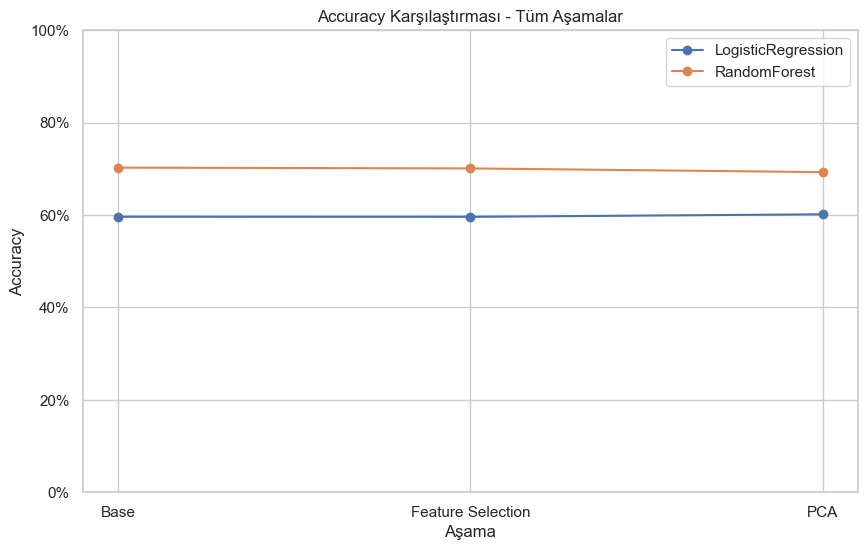

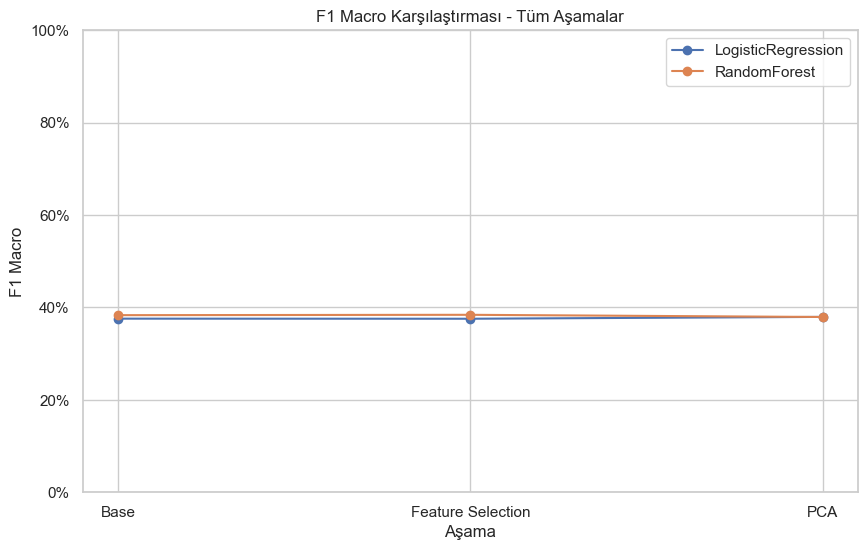

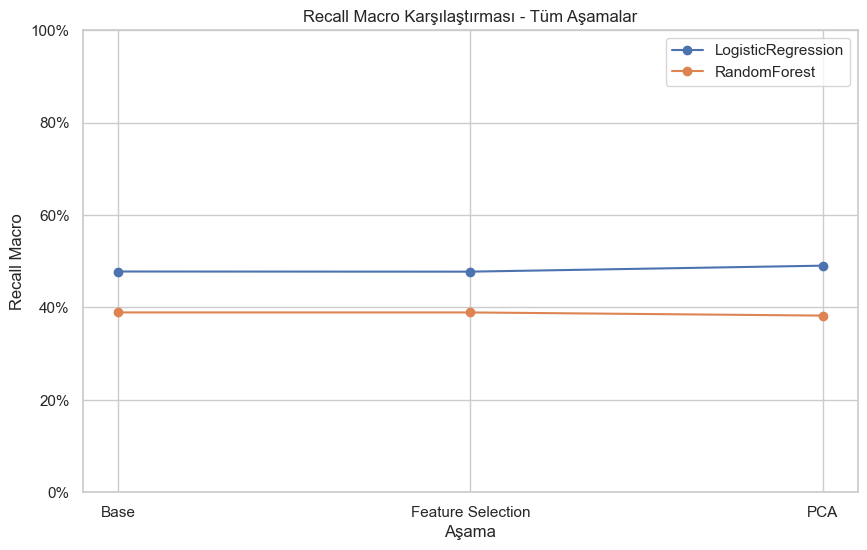

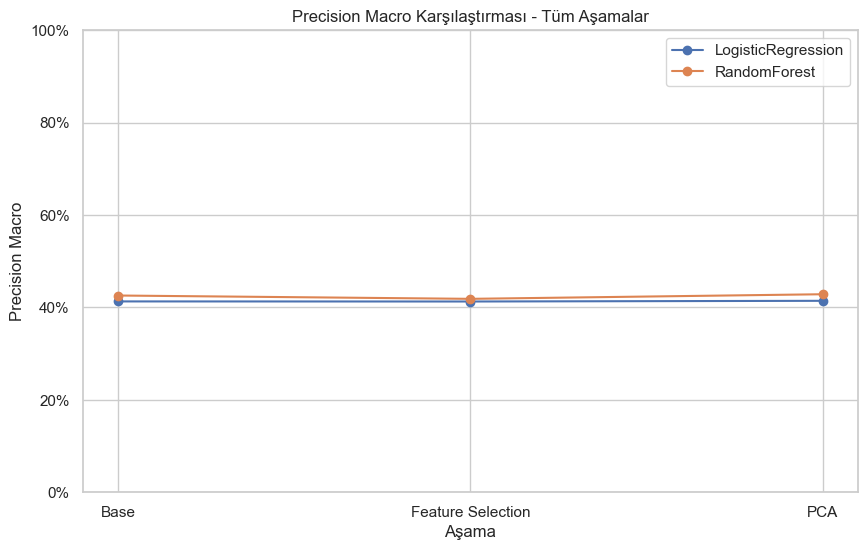

In [38]:
# 2. Görselleştirme
metrics = ['Accuracy', 'F1 Macro', 'Recall Macro', 'Precision Macro']
for metric in metrics:
    plt.figure(figsize=(10,6))
    for model in results_df['Model'].unique():
        subset = results_df[results_df['Model'] == model]
        plt.plot(subset['Stage'], subset[metric], marker='o', label=model)
    plt.title(f"{metric} Karşılaştırması - Tüm Aşamalar")
    plt.xlabel("Aşama")
    plt.ylabel(metric)
    plt.ylim(0,1)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    plt.grid(True)
    plt.legend()
    plt.show()

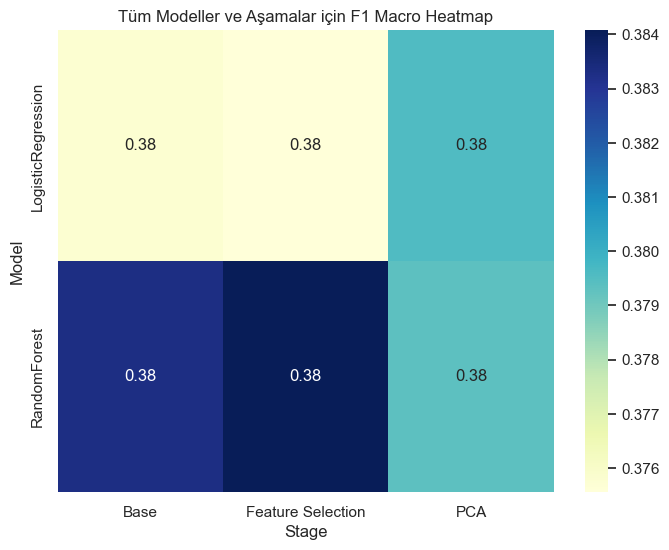

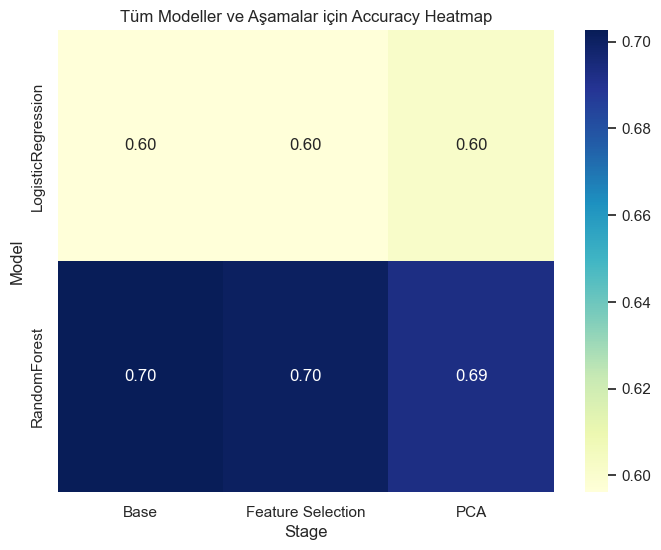

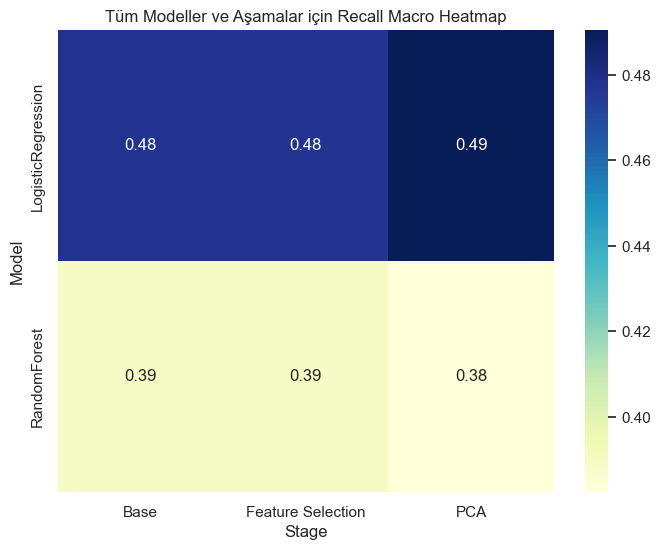

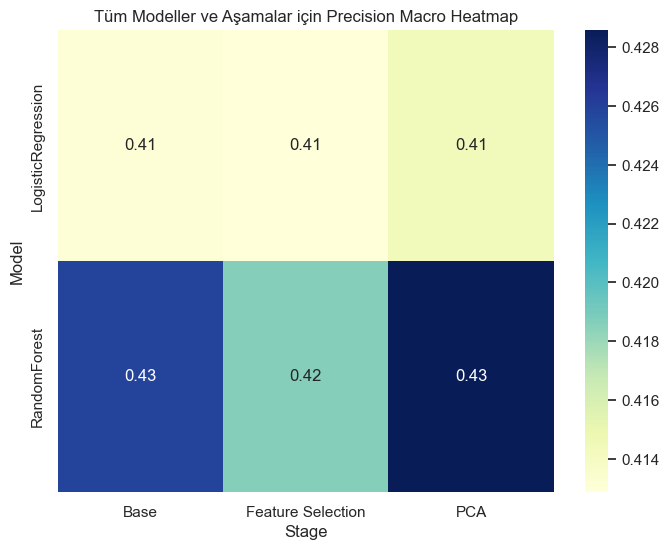

In [39]:
# 8. Test Sonuçlarını Heatmap ile Görselleştirme
for metric in ['F1 Macro', 'Accuracy', 'Recall Macro', 'Precision Macro']:
    heatmap_data = results_df.pivot_table(index='Model', columns='Stage', values=metric)
    plt.figure(figsize=(8,6))
    sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu")
    plt.title(f"Tüm Modeller ve Aşamalar için {metric} Heatmap")
    plt.show()

Bu modelleri kullanabilmek için önce gerekli kütüphanelerin yüklü olması ve hedef değişkenin (y) sayısal formata (0, 1, 2...) çevrilmesi gerekir. XGBoost ve LightGBM metin tabanlı etiketleri (Target) doğrudan kabul etmeyebilir.

In [45]:
# Hedef değişkeni sayısal hale getirelim (Örn: "NO INDICATION" -> 0, "FATAL" -> 1 gibi)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Veriyi tekrar bölelim (y_encoded kullanarak)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

print("Hedef değişken sınıfları:", le.classes_)

Hedef değişken sınıfları: ['FATAL' 'INCAPACITATING INJURY' 'NO INDICATION OF INJURY'
 'NONINCAPACITATING INJURY' 'REPORTED, NOT EVIDENT']


Adım 2: Ön İşleme Hattının (Pipeline) Kurulması:Bu güçlü modellerin veriyi doğru işleyebilmesi için kategorik ve sayısal verileri ayırıp işleyen bir pipeline kuralım.

In [46]:
# Kategorik ve Sayısal Sütunları Belirleme
categorical_cols = [col for col in X.columns if X[col].dtype == 'object']
numerical_cols = [col for col in X.columns if X[col].dtype in ['int64', 'float64']]

# Ön İşleme Adımları
# Sayısal veriler için: Eksik verileri medyan ile doldur ve ölçekle (StandardScaler)
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Kategorik veriler için: Eksik verileri 'MISSING' ile doldur ve OneHotEncode yap
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='MISSING')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Parçaları birleştirme
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

Adım 3: Birinci Güçlü Model - XGBoost
XGBoost (Extreme Gradient Boosting), hız ve performans açısından çok popülerdir. Özellikle dengesiz veri setlerinde ve karmaşık ilişkilerde çok başarılıdır.

In [48]:
# --- MODEL 1: XGBoost ---
print("XGBoost Modeli Eğitiliyor...")

# Modelin tanımlanması
xgb_model = XGBClassifier(
    n_estimators=200,     # Ağaç sayısı
    learning_rate=0.05,   # Öğrenme hızı
    max_depth=6,          # Ağaç derinliği
    random_state=42,
    n_jobs=-1,            # Tüm işlemcileri kullan
    eval_metric='mlogloss' # Çoklu sınıflandırma için hata metriği
)

# Pipeline ile birleştirme
xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', xgb_model)])

# Eğitme
xgb_pipeline.fit(X_train, y_train)

# Tahmin
y_pred_xgb = xgb_pipeline.predict(X_test)

# Sonuçları Yazdırma
print("\n--- XGBoost Sonuçları ---")
print(classification_report(y_test, y_pred_xgb, target_names=le.classes_))

XGBoost Modeli Eğitiliyor...

--- XGBoost Sonuçları ---
                          precision    recall  f1-score   support

                   FATAL       0.25      0.00      0.01       212
   INCAPACITATING INJURY       0.25      0.00      0.00      3282
 NO INDICATION OF INJURY       0.97      0.88      0.92     31395
NONINCAPACITATING INJURY       0.51      0.86      0.64     15977
   REPORTED, NOT EVIDENT       0.50      0.24      0.33      9131

                accuracy                           0.73     59997
               macro avg       0.50      0.40      0.38     59997
            weighted avg       0.73      0.73      0.70     59997



Adım 4: İkinci Güçlü Model - LightGBM
LightGBM, Microsoft tarafından geliştirilmiştir ve XGBoost'a göre genellikle daha hızlıdır ve daha az bellek kullanır. Büyük veri setlerinde çok etkilidir.

In [49]:
# --- MODEL 2: LightGBM ---
print("LightGBM Modeli Eğitiliyor...")

# Modelin tanımlanması
lgbm_model = LGBMClassifier(
    n_estimators=200,
    learning_rate=0.05,
    num_leaves=31,        # Yaprak sayısı (LightGBM'de derinlik yerine bu önemlidir)
    random_state=42,
    n_jobs=-1,
    verbose=-1            # Gereksiz uyarıları kapatmak için
)

# Pipeline ile birleştirme
lgbm_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('model', lgbm_model)])

# Eğitme
lgbm_pipeline.fit(X_train, y_train)

# Tahmin
y_pred_lgbm = lgbm_pipeline.predict(X_test)

# Sonuçları Yazdırma
print("\n--- LightGBM Sonuçları ---")
print(classification_report(y_test, y_pred_lgbm, target_names=le.classes_))

LightGBM Modeli Eğitiliyor...

--- LightGBM Sonuçları ---
                          precision    recall  f1-score   support

                   FATAL       0.22      0.02      0.03       212
   INCAPACITATING INJURY       0.25      0.00      0.00      3282
 NO INDICATION OF INJURY       0.97      0.88      0.92     31395
NONINCAPACITATING INJURY       0.51      0.86      0.64     15977
   REPORTED, NOT EVIDENT       0.49      0.26      0.34      9131

                accuracy                           0.73     59997
               macro avg       0.49      0.40      0.39     59997
            weighted avg       0.73      0.73      0.70     59997



zet ve Yorumlama
Bu adımları uyguladığınızda projenizde şu iyileştirmeleri göreceksiniz:

Daha Yüksek Başarı: Basit modellere göre (Logistic Regression gibi) karmaşık trafik kazası senaryolarını daha iyi öğreneceklerdir.

Hız: Özellikle LightGBM, 300.000 satırlık verinizi oldukça hızlı eğitecektir.

Özellik Önemi (Feature Importance): Bu modellerin en güzel yanı, hangi faktörün (Hava durumu mu? Yol tipi mi? Hız sınırı mı?) kazanın şiddetini en çok etkilediğini size söyleyebilmesidir.

In [50]:
# XGBoost için Özellik Önem Düzeyleri
feature_names = (xgb_pipeline.named_steps['preprocessor']
                 .transformers_[1][1]
                 .named_steps['onehot']
                 .get_feature_names_out(categorical_cols))
all_features = numerical_cols + list(feature_names)

import pandas as pd
importances = xgb_pipeline.named_steps['model'].feature_importances_
df_imp = pd.DataFrame({'Feature': all_features, 'Importance': importances})
print(df_imp.sort_values(by='Importance', ascending=False).head(10))

                                         Feature  Importance
108  CRASH_TYPE_INJURY AND / OR TOW DUE TO CRASH    0.746089
57         FIRST_CRASH_TYPE_PARKED MOTOR VEHICLE    0.032695
60                     FIRST_CRASH_TYPE_REAR END    0.023674
59                   FIRST_CRASH_TYPE_PEDESTRIAN    0.023643
58                 FIRST_CRASH_TYPE_PEDALCYCLIST    0.020332
49                    LIGHTING_CONDITION_UNKNOWN    0.004953
65     FIRST_CRASH_TYPE_SIDESWIPE SAME DIRECTION    0.003982
112                           DAMAGE_OVER $1,500    0.003749
52                 FIRST_CRASH_TYPE_FIXED OBJECT    0.003389
1                                      NUM_UNITS    0.003209


In [52]:
# --- 1. FONKSİYON: Performans Metriklerini Hesapla ---
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    
    # Metrikleri hesapla (Weighted: Sınıf dengesizliği varsa ağırlıklı ortalama alır)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    return [model_name, acc, prec, rec, f1], y_pred

In [53]:
# --- 2. SONUÇLARI HESAPLAMA ---
# XGBoost Sonuçları
xgb_metrics, xgb_pred = evaluate_model(xgb_pipeline, X_test, y_test, "XGBoost")

# LightGBM Sonuçları
lgbm_metrics, lgbm_pred = evaluate_model(lgbm_pipeline, X_test, y_test, "LightGBM")

# Tablo oluşturma
df_results = pd.DataFrame([xgb_metrics, lgbm_metrics], 
                          columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score"])

print("\n--- Model Performans Tablosu ---")
display(df_results)


--- Model Performans Tablosu ---


,Model,Accuracy,Precision,Recall,F1 Score
0,XGBoost,0.726203,0.733375,0.726203,0.702609
1,LightGBM,0.726420,0.732792,0.726420,0.704404


Text(192.25, 0.5, 'Gerçek Değer')

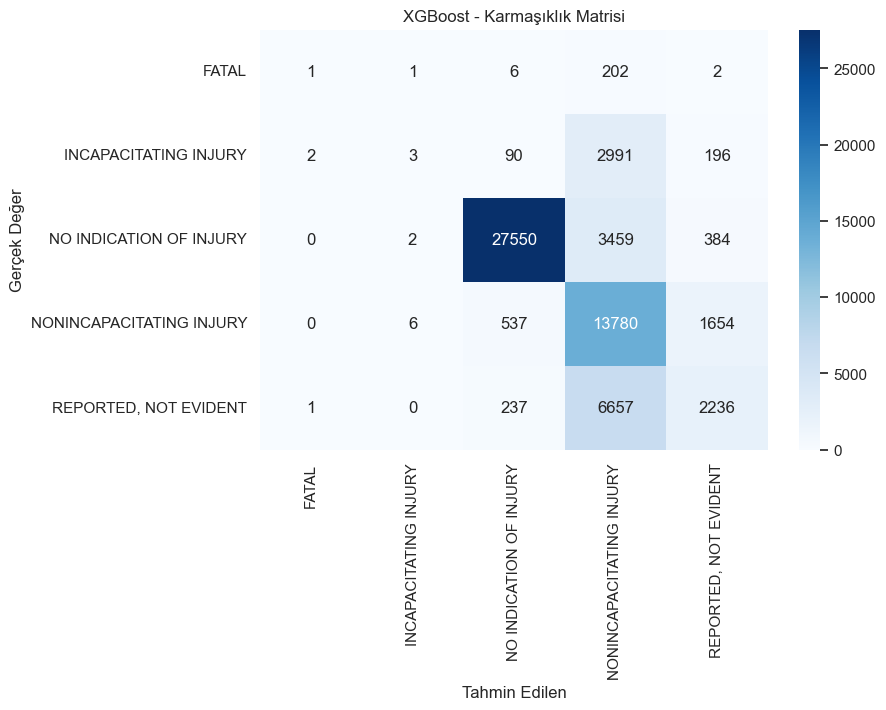

In [54]:
# --- 3. GÖRSELLEŞTİRME ---
plt.figure(figsize=(18, 12))

# GRAFİK 1: XGBoost Confusion Matrix
plt.subplot(2, 2, 1)
cm_xgb = confusion_matrix(y_test, xgb_pred)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('XGBoost - Karmaşıklık Matrisi')
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek Değer')

Text(317.7954545454545, 0.5, 'Gerçek Değer')

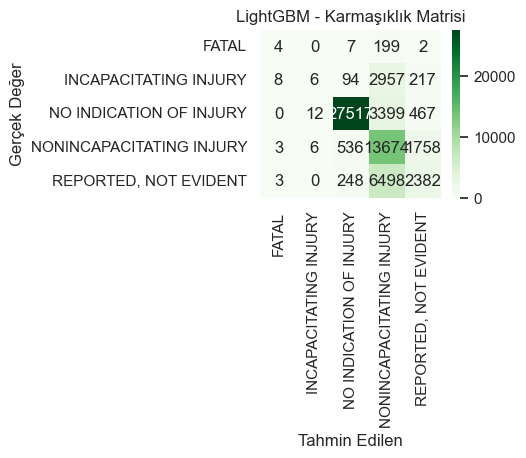

In [55]:
# GRAFİK 2: LightGBM Confusion Matrix
plt.subplot(2, 2, 2)
cm_lgbm = confusion_matrix(y_test, lgbm_pred)
sns.heatmap(cm_lgbm, annot=True, fmt='d', cmap='Greens', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('LightGBM - Karmaşıklık Matrisi')
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek Değer')

Text(0.5, 0, 'Önem Düzeyi')

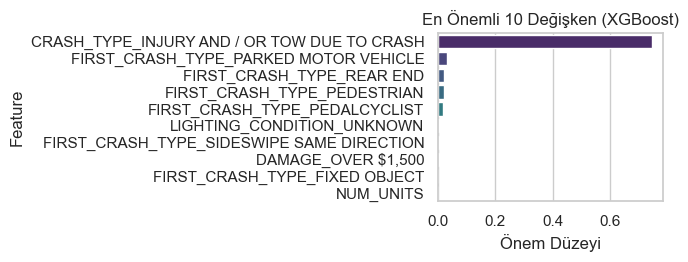

In [56]:
# GRAFİK 3: Feature Importance (Sadece XGBoost için örnek)
plt.subplot(2, 2, 3)

# Pipeline içinden model ve özellik isimlerini çekme
model_step = xgb_pipeline.named_steps['model']
preprocessor_step = xgb_pipeline.named_steps['preprocessor']

# Kategorik özellik isimlerini OneHotEncoder'dan al
cat_feature_names = preprocessor_step.transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_cols)
all_feature_names = numerical_cols + list(cat_feature_names)

# Önem değerlerini al ve DataFrame yap
importances = model_step.feature_importances_
df_imp = pd.DataFrame({'Feature': all_feature_names, 'Importance': importances})
df_imp = df_imp.sort_values(by='Importance', ascending=False).head(10) # En önemli 10 özellik

sns.barplot(x='Importance', y='Feature', data=df_imp, palette='viridis')
plt.title('En Önemli 10 Değişken (XGBoost)')
plt.xlabel('Önem Düzeyi')

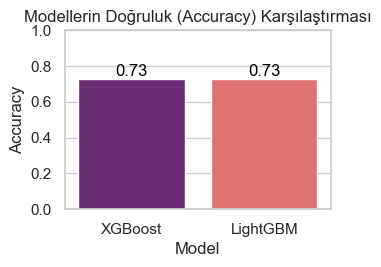

In [57]:
# GRAFİK 4: Model Karşılaştırması (Accuracy)
plt.subplot(2, 2, 4)
sns.barplot(x='Model', y='Accuracy', data=df_results, palette='magma')
plt.ylim(0, 1) # 0 ile 1 arasında sınırla
for index, row in df_results.iterrows():
    plt.text(index, row.Accuracy + 0.02, f"{row.Accuracy:.2f}", color='black', ha="center")
plt.title('Modellerin Doğruluk (Accuracy) Karşılaştırması')

plt.tight_layout()
plt.show()

Karmaşıklık Matrisi (Heatmaps):

Köşegen (sol üstten sağ alta) üzerindeki koyu renkli kutular doğru tahminleri gösterir.

Eğer köşegen dışında çok sayı (koyu renk) görüyorsanız, model o sınıfları birbiriyle karıştırıyor demektir. Örneğin: Model "Ağır Yaralanma"yı "Hafif Yaralanma" olarak tahmin ediyorsa, bu tehlikeli bir hatadır.

Feature Importance (Önemli Değişkenler):

Bu grafik size projenizin hikayesini anlatır. Eğer en tepede SPEED_LIMIT (Hız Sınırı) veya WEATHER_RAIN (Yağmurlu Hava) varsa, "Hız sınırları ve hava durumu kazaların ciddiyetinde en belirleyici faktörlerdir" 

Accuracy Karşılaştırması:

Hangi modelin çubuğu daha yüksekse, o model genel olarak daha başarılıdır. Ancak F1 Score'a da tabloda dikkat edin; eğer veriniz dengesizse (çok kaza var ama az ölüm varsa) F1 skoru Accuracy'den daha önemli bir göstergedir.

In [60]:
# --- ADIM 1: Basit Modelleri Pipeline ile Tanımlayalım ---
# Logistic Regression (Basit Model 1)
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(max_iter=10, random_state=42))
])

# Random Forest (Basit Model 2)
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(n_estimators=10, random_state=42))
])

# --- ADIM 2: Tüm Modelleri Bir Listeye Alıp Döngü ile Çalıştıralım ---
all_models = [
    ("Logistic Regression", lr_pipeline),
    ("Random Forest", rf_pipeline),
    ("XGBoost", xgb_pipeline),
    ("LightGBM", lgbm_pipeline)
]

results_list = []

print("Modeller karşılaştırılıyor, lütfen bekleyiniz...")

for name, model in all_models:
    # Modeli eğit
    model.fit(X_train, y_train)
    
    # Tahmin yap
    y_pred = model.predict(X_test)
    
    # Metrikleri hesapla
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted') # Dengesiz veri için Weighted F1 önemli
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    
    results_list.append({
        "Model": name,
        "Accuracy": acc,
        "F1 Score": f1,
        "Precision": prec
    })



Modeller karşılaştırılıyor, lütfen bekleyiniz...



--- BÜYÜK MODEL KARŞILAŞTIRMASI ---


,Model,Accuracy,F1 Score,Precision
3,LightGBM,0.726420,0.704404,0.732792
2,XGBoost,0.726203,0.702609,0.733375
0,Logistic Regression,0.723253,0.698577,0.714642
1,Random Forest,0.693118,0.682441,0.681698


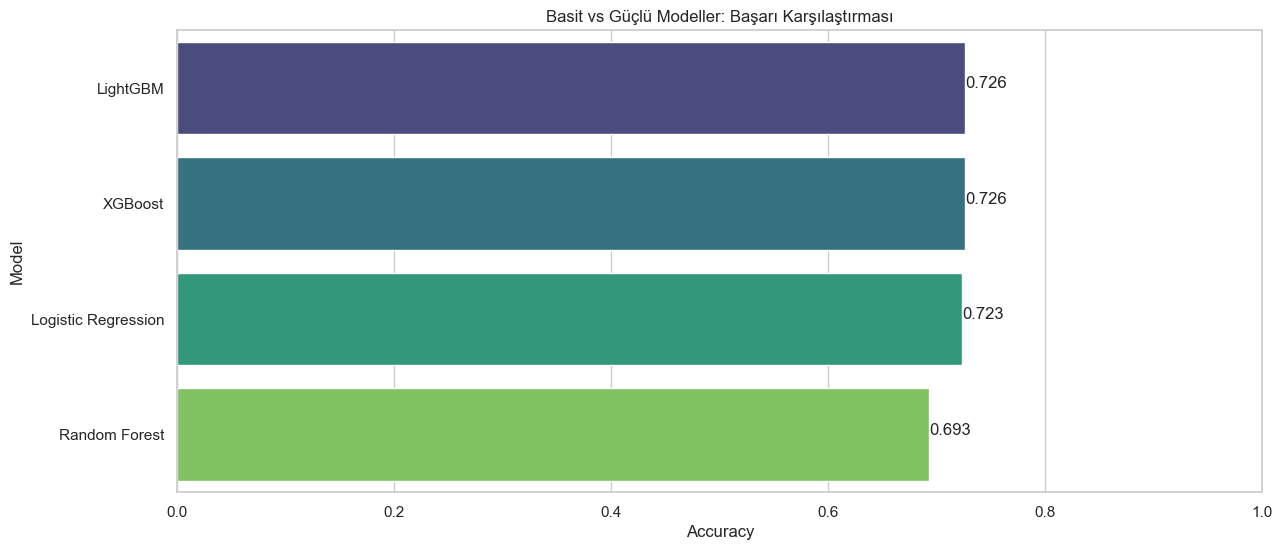

In [61]:
# --- ADIM 3: Sonuç Tablosu ve Görselleştirme ---
df_comparison = pd.DataFrame(results_list).sort_values(by='F1 Score', ascending=False)

print("\n--- BÜYÜK MODEL KARŞILAŞTIRMASI ---")
display(df_comparison)

# Grafiğe dökelim
plt.figure(figsize=(14, 6))
sns.barplot(x='Accuracy', y='Model', data=df_comparison, palette='viridis')
plt.title('Basit vs Güçlü Modeller: Başarı Karşılaştırması')
plt.xlim(0, 1.0)
for index, value in enumerate(df_comparison['Accuracy']):
    plt.text(value, index, f'{value:.3f}')
plt.show()

Adım 5: Hiperparametre Optimizasyonu (Tuning) Kodu

In [62]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# --- 1. XGBoost İçin İnce Ayar (Tuning) ---
print("--- XGBoost İçin En İyi Ayarlar Aranıyor (Lütfen bekleyiniz)... ---")

# Aranacak parametre aralıkları
param_dist_xgb = {
    'model__n_estimators': randint(100, 500),      # Ağaç sayısı: 100 ile 500 arası
    'model__learning_rate': uniform(0.01, 0.2),    # Öğrenme hızı: 0.01 ile 0.21 arası
    'model__max_depth': randint(3, 10),            # Derinlik: 3 ile 10 arası
    'model__subsample': uniform(0.6, 0.4),         # Verinin ne kadarını kullansın (0.6-1.0)
    'model__colsample_bytree': uniform(0.6, 0.4)   # Sütunların ne kadarını kullansın
}

# Arama motorunu kuruyoruz
random_search_xgb = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=param_dist_xgb,
    n_iter=10,           # 10 farklı kombinasyon denenecek (Sayısı artarsa başarı artar ama süre uzar)
    cv=3,                # 3 katlı çapraz doğrulama (Güvenilir sonuç için)
    scoring='accuracy',  # Hedefimiz: Doğruluk
    n_jobs=-1,           # Tüm işlemcileri kullan (Hız için)
    random_state=42,
    verbose=1
)

# Aramayı başlat
random_search_xgb.fit(X_train, y_train)

print(f"XGBoost En İyi Parametreler: {random_search_xgb.best_params_}")
print(f"XGBoost En İyi Skor (Eğitim Setinde): {random_search_xgb.best_score_:.4f}")

# --- 2. LightGBM İçin İnce Ayar (Tuning) ---
print("\n--- LightGBM İçin En İyi Ayarlar Aranıyor... ---")

param_dist_lgbm = {
    'model__n_estimators': randint(100, 500),
    'model__learning_rate': uniform(0.01, 0.2),
    'model__num_leaves': randint(20, 100),         # Yaprak sayısı (Derinlik yerine bu kullanılır)
    'model__subsample': uniform(0.6, 0.4),
    'model__colsample_bytree': uniform(0.6, 0.4)
}

random_search_lgbm = RandomizedSearchCV(
    estimator=lgbm_pipeline,
    param_distributions=param_dist_lgbm,
    n_iter=10,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

random_search_lgbm.fit(X_train, y_train)

print(f"LightGBM En İyi Parametreler: {random_search_lgbm.best_params_}")
print(f"LightGBM En İyi Skor (Eğitim Setinde): {random_search_lgbm.best_score_:.4f}")


--- XGBoost İçin En İyi Ayarlar Aranıyor (Lütfen bekleyiniz)... ---
Fitting 3 folds for each of 10 candidates, totalling 30 fits
XGBoost En İyi Parametreler: {'model__colsample_bytree': 0.6923575302488596, 'model__learning_rate': 0.05820509320520235, 'model__max_depth': 6, 'model__n_estimators': 363, 'model__subsample': 0.6137554084460873}
XGBoost En İyi Skor (Eğitim Setinde): 0.7278

--- LightGBM İçin En İyi Ayarlar Aranıyor... ---
Fitting 3 folds for each of 10 candidates, totalling 30 fits
LightGBM En İyi Parametreler: {'model__colsample_bytree': 0.7599443886861021, 'model__learning_rate': 0.019333132642723086, 'model__n_estimators': 287, 'model__num_leaves': 99, 'model__subsample': 0.6931085361721216}
LightGBM En İyi Skor (Eğitim Setinde): 0.7278


In [63]:
# --- 3. GÜNCELLENMİŞ SONUÇLARI GÖRME ---
# En iyi modellerle test setini tahmin edelim
best_xgb_model = random_search_xgb.best_estimator_
best_lgbm_model = random_search_lgbm.best_estimator_

print("\n--- OPTİMİZE EDİLMİŞ MODELLERİN TEST SONUÇLARI ---")

# XGBoost Test
y_pred_best_xgb = best_xgb_model.predict(X_test)
print("\n-> Optimize Edilmiş XGBoost:")
print(classification_report(y_test, y_pred_best_xgb, target_names=le.classes_))

# LightGBM Test
y_pred_best_lgbm = best_lgbm_model.predict(X_test)
print("\n-> Optimize Edilmiş LightGBM:")
print(classification_report(y_test, y_pred_best_lgbm, target_names=le.classes_))


--- OPTİMİZE EDİLMİŞ MODELLERİN TEST SONUÇLARI ---

-> Optimize Edilmiş XGBoost:
                          precision    recall  f1-score   support

                   FATAL       0.33      0.00      0.01       212
   INCAPACITATING INJURY       0.29      0.00      0.00      3282
 NO INDICATION OF INJURY       0.97      0.88      0.92     31395
NONINCAPACITATING INJURY       0.51      0.86      0.64     15977
   REPORTED, NOT EVIDENT       0.50      0.26      0.34      9131

                accuracy                           0.73     59997
               macro avg       0.52      0.40      0.38     59997
            weighted avg       0.74      0.73      0.70     59997


-> Optimize Edilmiş LightGBM:
                          precision    recall  f1-score   support

                   FATAL       0.22      0.01      0.02       212
   INCAPACITATING INJURY       0.48      0.00      0.01      3282
 NO INDICATION OF INJURY       0.97      0.88      0.92     31395
NONINCAPACITATING INJURY 

Arama (Search): Modelinize "Ağaç sayısı 100 mü olsun 500 mü?", "Öğrenme hızı hızlı mı olsun yavaş mı?" diye sorarak en iyi kombinasyonu deniyor.

CV (Cross Validation): Sonuçların şans eseri çıkmadığından emin olmak için veriyi 3 parçaya bölüp her parçada test ediyor.

Sonuç: best_params_ kısmında size "En iyi ayar şudur" diyecek. Sonrasında bu en iyi ayarlarla tekrar tahmin yapıp (predict) sonuçları raporlayacak.